In [1]:
# Check loaded modules
! module list
! python3 -m venv mofa_venv
! source mofa_venv/bin/activate

# Upgrade pip
! pip3 install --upgrade pip setuptools wheel

# Verify you're using the virtual environment
! which python  # Should show path with mofa_venv


Currently Loaded Modules:
  1) stack/2024-05   3) cuda/12.2.1          5) eth_proxy   7) hdf5/1.14.3
  2) gcc/13.2.0      4) python/3.11.6_cuda   6) r/4.3.2     8) julia/1.10.3

 

Defaulting to user installation because normal site-packages is not writeable
/cluster/software/stacks/2024-05/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-13.2.0/python-3.11.6-m4n2ny4dwaqmeobuqquo3gpyw2bct67i/bin/python


In [2]:
! export PATH=/cluster/home/taekim/.local/bin:$PATH
! echo 'export PATH=/cluster/home/taekim/.local/bin:$PATH' >> ~/.bashrc

# 2. Clean up the corrupted numpy
! rm -rf /cluster/home/taekim/.local/lib/python3.11/site-packages/~umpy*

# 3. Create a clean virtual environment (RECOMMENDED)
! python -m venv ~/mofa_clean_env
! source ~/mofa_clean_env/bin/activate

! pip3 install mofapy2

# 5. Test it works
! python -c "import mofapy2; import numpy; print('MOFA is ready!')"

Defaulting to user installation because normal site-packages is not writeable
MOFA is ready!


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import umap

In [19]:
# Data specific helper functions

def extract_group_expr(sample):
    parts = sample.split('_')
    if len(parts) >= 3:
        return f"{parts[1]}_{parts[2]}"
    return "Unknown"

def extract_group_oxid(sample):
    parts = sample.split('_')
    if len(parts) >= 5:
        return f"{parts[2]}_{parts[3]}"
    return "Unknown"

def load_data(EXPR_PATH, OXID_PATH):
    print("Loading expression data...")
    expr_df = pd.read_csv(EXPR_PATH)
    
    print("Loading oxidation data...")
    oxid_df = pd.read_csv(OXID_PATH)
    
    expr_df['Group'] = expr_df['Sample'].apply(extract_group_expr)
    oxid_df['Group'] = oxid_df['sample'].apply(extract_group_oxid)
   
    return expr_df, oxid_df

def normalize_sample_names(sample_name, dataset_type='oxidation'):

    if dataset_type == 'oxidation':
        # Remove 'Sample_' prefix and '_S#_' suffix
        if sample_name.startswith('Sample_'):
            # Remove 'Sample_' prefix
            clean_name = sample_name[7:]  # Remove first 7 characters
            
            # Remove '_S#_' suffix (find last occurrence of '_S' and remove everything after)
            if '_S' in clean_name:
                # Find the last '_S' pattern
                parts = clean_name.split('_S')
                if len(parts) > 1:
                    # Take everything before the last '_S'
                    clean_name = parts[0]
            
            return clean_name
        
    return sample_name  # Return unchanged if expression or doesn't match pattern

In [20]:
def prepare_mofa_data_filter_optimal(expr_df, oxid_df, target_genes_per_group=15000):

    print("\n" + "="*80)
    print("PREPARING DATA FOR MOFA ANALYSIS - OPTIMAL VERSION")
    print("="*80)
    
    # Extract group information
    expr_df['Group'] = expr_df['Sample'].apply(extract_group_expr)
    oxid_df['Group'] = oxid_df['sample'].apply(extract_group_oxid)
    expr_df['Sample_normalized'] = expr_df['Sample'].apply(lambda x: normalize_sample_names(x, 'expression'))
    oxid_df['Sample_normalized'] = oxid_df['sample'].apply(lambda x: normalize_sample_names(x, 'oxidation'))
    
    gene_col_expr = 'Gene'
    gene_col_oxid = 'gene'
    
    common_groups = expr_df['Group'].unique()
    all_genes = expr_df[gene_col_expr].unique()
    
    print(f"Common groups: {list(common_groups)}")
    print(f"Total genes: {len(all_genes):,}")
    print(f"Target genes per group: {target_genes_per_group:,}")
    
    # STEP 1: Light zero-inflation filtering (less aggressive than integrated)
    print(f"\nSTEP 1: Light zero-inflation filtering")
    
    expr_matrix = expr_df.pivot_table(
        index=gene_col_expr, columns='Sample', values='Expression_level', fill_value=0
    )
    
    # Much more permissive filtering than integrated version
    min_expression_level = 0.2  # Lower threshold (was 0.5)
    min_samples_expressed = 1   # Fewer samples required (was 5)
    
    expressed_matrix = expr_matrix >= min_expression_level
    expressed_counts = expressed_matrix.sum(axis=1)
    expressed_genes = expressed_counts[expressed_counts >= min_samples_expressed].index.tolist()
    
    print(f"  Using threshold {min_expression_level} in ≥{min_samples_expressed} samples")
    print(f"  Genes remaining: {len(expressed_genes):,} (was {len(all_genes):,})")
    print(f"  Filtered out: {len(all_genes) - len(expressed_genes):,} genes ({100*(len(all_genes) - len(expressed_genes))/len(all_genes):.1f}%)")
    
    mofa_data = []
    sample_metadata = []
    
    for group in common_groups:
        print(f"\nProcessing group: {group}")
        
        # Filter to expressed genes
        expr_group = expr_df[
            (expr_df['Group'] == group) & 
            (expr_df[gene_col_expr].isin(expressed_genes))
        ]
        
        oxid_group = oxid_df[
            (oxid_df['Group'] == group) & 
            (oxid_df[gene_col_oxid].isin(expressed_genes))
        ]
        
        if len(expr_group) == 0 or len(oxid_group) == 0:
            continue
            
        # Create pivot tables
        expr_pivot = expr_group.pivot_table(
            index=gene_col_expr, columns='Sample_normalized', 
            values='Expression_level', fill_value=0
        )
        
        oxid_pivot = oxid_group.pivot_table(
            index=gene_col_oxid, columns='Sample_normalized',
            values='median_normalized_damage', fill_value=np.nan
        )
        
        # Get common genes and samples
        common_genes_group = list(set(expr_pivot.index) & set(oxid_pivot.index))
        expr_samples_norm = set(expr_group['Sample_normalized'].unique())
        oxid_samples_norm = set(oxid_group['Sample_normalized'].unique())
        common_samples = list(expr_samples_norm & oxid_samples_norm)
        
        print(f"  Common samples: {len(common_samples)}")
        print(f"  Common genes after expression filtering: {len(common_genes_group)}")
        
        if len(common_genes_group) < 100 or len(common_samples) < 3:
            continue
            
        # Align matrices
        expr_aligned = expr_pivot.loc[common_genes_group, common_samples]
        oxid_aligned = oxid_pivot.loc[common_genes_group, common_samples].fillna(
            oxid_pivot.loc[common_genes_group, common_samples].mean(axis=1), axis=0
        )
        
        # STEP 2: Moderate variance filtering (key change!)
        print(f"  Step 2: Moderate variance filtering (target: {target_genes_per_group:,} genes)")
        
        expr_variance = expr_aligned.var(axis=1)
        oxid_variance = oxid_aligned.var(axis=1)
        
        print(f"    Expression variance - Min: {expr_variance.min():.6f}, Median: {expr_variance.median():.6f}, Max: {expr_variance.max():.6f}")
        print(f"    Oxidation variance - Min: {oxid_variance.min():.6f}, Median: {oxid_variance.median():.6f}, Max: {oxid_variance.max():.6f}")
        
        # Calculate what percentile gives us target number of genes
        total_available = len(common_genes_group)
        target_fraction = min(1.0, target_genes_per_group / total_available)
        target_percentile = 1.0 - target_fraction
        
        print(f"    Target: {target_genes_per_group:,} genes from {total_available:,} available")
        print(f"    Using {target_percentile:.1%} percentile cutoff")
        
        # Apply percentile-based filtering
        expr_threshold = expr_variance.quantile(target_percentile)
        oxid_threshold = oxid_variance.quantile(target_percentile)
        
        high_var_genes = list(set(
            expr_variance[expr_variance > expr_threshold].index
        ) | set(
            oxid_variance[oxid_variance > oxid_threshold].index
        ))
        
        print(f"    Selected {len(high_var_genes):,} genes")
        
        # Apply filtering
        expr_filtered = expr_aligned.loc[high_var_genes, common_samples]
        oxid_filtered = oxid_aligned.loc[high_var_genes, common_samples]
        
        # Check for remaining zero-variance genes and remove them
        expr_var_final = expr_filtered.var(axis=1)
        oxid_var_final = oxid_filtered.var(axis=1)
        
        non_zero_var_genes = list(set(
            expr_var_final[expr_var_final > 0].index
        ) | set(
            oxid_var_final[oxid_var_final > 0].index
        ))
        
        if len(non_zero_var_genes) < len(high_var_genes):
            print(f"    Removed {len(high_var_genes) - len(non_zero_var_genes)} zero-variance genes")
            expr_filtered = expr_filtered.loc[non_zero_var_genes, common_samples]
            oxid_filtered = oxid_filtered.loc[non_zero_var_genes, common_samples]
            high_var_genes = non_zero_var_genes
        
        # STEP 3: Standardization
        print(f"  Step 3: Standardization")
        from sklearn.preprocessing import StandardScaler
        
        scaler_expr = StandardScaler()
        scaler_oxid = StandardScaler()
        
        expr_standardized = scaler_expr.fit_transform(expr_filtered.T).T
        oxid_standardized = scaler_oxid.fit_transform(oxid_filtered.T).T
        
        expr_final = pd.DataFrame(expr_standardized, index=expr_filtered.index, columns=expr_filtered.columns)
        oxid_final = pd.DataFrame(oxid_standardized, index=oxid_filtered.index, columns=oxid_filtered.columns)
        
        print(f"    Final data shape: {expr_final.shape}")
        print(f"    Expression range: [{expr_final.values.min():.3f}, {expr_final.values.max():.3f}]")
        print(f"    Oxidation range: [{oxid_final.values.min():.3f}, {oxid_final.values.max():.3f}]")
        
        # Store data
        group_data = {
            'expression': expr_final.values,
            'oxidation': oxid_final.values,
            'feature_names': {
                'expression': high_var_genes,
                'oxidation': high_var_genes
            },
            'sample_names': common_samples,
            'group_name': group
        }
        
        mofa_data.append(group_data)
        
        for sample in common_samples:
            sample_metadata.append({'sample': sample, 'group': group})
    
    print(f"\nFinal MOFA dataset:")
    print(f"  Groups: {len(mofa_data)}")
    print(f"  Total samples: {len(sample_metadata)}")
    avg_genes = sum(len(g['feature_names']['expression']) for g in mofa_data) / len(mofa_data)
    print(f"  Average genes per group: {avg_genes:.0f}")
    
    return mofa_data, pd.DataFrame(sample_metadata)



In [21]:
# Step 2

def run_mofa_analysis(mofa_data, sample_metadata, output_dir="./mofa_output/"):

    try:
        # Import what works for v0.7.2
        from mofapy2.run.entry_point import entry_point
        from mofapy2.core.BayesNet import BayesNet
        print("✅ mofapy2 v0.7.2 imports successful!")
    except ImportError as e:
        print(f"❌ Import failed: {e}")
    
        
    print("\n" + "="*80)
    print("RUNNING MOFA ANALYSIS")
    print("="*80)
    
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Prepare data as single DataFrame for MOFA
    all_rows = []

    for group_data in mofa_data:
        group_name = group_data['group_name']
        print(group_name)
        samples = group_data['sample_names']
    
        # Expression data - convert to long format
        expr_genes = group_data['feature_names']['expression']
        expr_values = group_data['expression']  # genes x samples
    
        for i, gene in enumerate(expr_genes):
            for j, sample in enumerate(samples):
                all_rows.append({
                    'sample': sample,
                    'feature': gene,
                    'value': expr_values[i, j],
                    'view': 'expression',
                    'group': group_name
                })
    
        # Oxidation data - convert to long format  
        oxid_genes = group_data['feature_names']['oxidation']
        oxid_values = group_data['oxidation']  # genes x samples
    
        for i, gene in enumerate(oxid_genes):
            for j, sample in enumerate(samples):
                all_rows.append({
                    'sample': sample,
                    'feature': gene, 
                    'value': oxid_values[i, j],
                    'view': 'oxidation',
                    'group': group_name
                })

    # Concatenate all data
    mofa_df = pd.DataFrame(all_rows)

    ent = entry_point()

    ent.set_data_df(mofa_df, likelihoods=['gaussian', 'gaussian'])
    print(mofa_df['group'].unique()) # Check unique group labels

    # Set model options
    ent.set_model_options(
        factors=3,  # Maximum number of factors
        spikeslab_weights=True,  # Use spike-and-slab for sparsity
        ard_factors=True,  # Automatic relevance determination
        ard_weights=True
    )
    
    # Set training options - FIXED: removed unsupported parameter
    ent.set_train_options(
        iter=2000,
        convergence_mode="medium",
        verbose=False,
        seed=42
    )
    
    # Build and run model
    print("Building MOFA model...")
    ent.build()
    
    print("Training MOFA model...")
    ent.run()
    
    # Save model
    model_file = os.path.join(output_dir, "mofa_model.hdf5")
    
    return ent, model_file

In [22]:
def analyze_mofa_results(mofa_model, sample_metadata, output_dir="./mofa_output/"):

    print("\n" + "="*80)
    print("ANALYZING MOFA RESULTS")
    print("="*80)
    
    os.makedirs(output_dir, exist_ok=True)
    
    # For mofapy2 v0.7.2, we need to access the model differently
    # The model is stored in mofa_model.model after training
    model = mofa_model.model
    
    # Get factor values from the model nodes
    Z = model.nodes['Z'].getExpectation()  # Factors
    W = model.nodes['W'].getExpectation()  # Weights
    
    views = mofa_model.data_opts['views_names']
    features_names = mofa_model.data_opts['features_names']
    
    # Sample size per group too small for multi-group MOFA
    # Single group MOFA - Z is a single array (samples x factors)
    # This implies all samples from all defined 'groups' in data_opts were effectively concatenated for the rows of the Z matrix.
    print("Single group MOFA")
    all_factors = []

    # 1. Get the flat list of all sample names in the order MOFA uses for the single Z matrix.
    # np.concatenate flattens the list of arrays from 'samples_names'.
    all_mofa_ordered_samples = np.concatenate(mofa_model.data_opts['samples_names'])

    # 2. Get the corresponding flat list of group assignments for these samples.
    # 'samples_groups' from data_opts is already in this flat, ordered format.
    all_mofa_ordered_groups = mofa_model.data_opts['samples_groups']

    # Iterate based on the rows of Z, using the ordered sample and group names
    for i in range(Z.shape[0]): 
        sample_name = all_mofa_ordered_samples[i]
        group_name_for_sample = all_mofa_ordered_groups[i]
            
        for k in range(Z.shape[1]):  # Iterate through factors (columns of Z)
            all_factors.append({
                'sample': sample_name,
                'group': group_name_for_sample, # Group from original data structure
                'factor': f'Factor{k+1}',
                'value': Z[i, k]
            })
    
    # Print summary statistics for each factor
    print("\n" + "="*60)
    print("FACTOR SUMMARY STATISTICS")
    print("="*60)
    for k in range(Z.shape[1]):
        factor_values = Z[:, k]
        print(f"\nFactor{k+1}:")
        print(f"  Mean:   {np.mean(factor_values):+8.4f}")
        print(f"  Std:    {np.std(factor_values):8.4f}")
        print(f"  Min:    {np.min(factor_values):+8.4f}")
        print(f"  Max:    {np.max(factor_values):+8.4f}")
        print(f"  Range:  {np.max(factor_values) - np.min(factor_values):8.4f}")
         
    factors_df = pd.DataFrame(all_factors).pivot_table(
        index=['sample', 'group'],
        columns='factor',
        values='value'
    )

    # Print the factors DataFrame
    print("\n" + "="*60)
    print("FACTORS DATAFRAME")
    print("="*60)
    print(factors_df)
    print(f"\nDataFrame shape: {factors_df.shape}")

    # Organize weights into a DataFrame
    all_weights = []
    for v, view in enumerate(views):
        # FIX: Use integer index v instead of string view
        view_weights = W[v]   # features x factors - W is a list, not a dict!

        # Get features for this view - also need to use integer index
        if isinstance(features_names, list):
            features = features_names[v]
        else:
            # features_names might be a dict
            features = features_names[view]

        for i, feature in enumerate(features):
            for k in range(view_weights.shape[1]):
                all_weights.append({
                    'view': view,
                    'feature': feature,
                    'factor': f'Factor{k+1}',
                    'weight': view_weights[i, k]
                })

    weights_df = pd.DataFrame(all_weights).pivot_table(
        index=['view', 'feature'],
        columns='factor',
        values='weight'
    )

    print(f"Factors shape: {factors_df.shape}")
    print(f"Weights shape: {weights_df.shape}")

    # Calculate variance explained manually
    var_explained = calculate_variance_explained(model, mofa_model)

    # Create visualizations
    create_mofa_plots(mofa_model, factors_df, weights_df, var_explained, output_dir)

    # Print interpretation
    interpret_mofa_factors(mofa_model, factors_df, weights_df, var_explained)

    return {
        'factors': factors_df,
        'weights': weights_df,
        'variance_explained': var_explained,
        'model': mofa_model
    }

def calculate_variance_explained(model, mofa_model):
    """
    Calculate R² (variance explained) for each factor
    """
    Z = model.nodes['Z'].getExpectation()
    W = model.nodes['W'].getExpectation()
    Y = model.nodes['Y'].getExpectation()
    
    views = mofa_model.data_opts['views_names']
    n_factors = Z.shape[1]
    
    var_explained = {}
    
    for v, view in enumerate(views):
        view_weights = W[v]
        view_data = Y[v].T  # Transpose once here, outside the loop
        
        # Calculate R² for each factor
        view_r2 = []
        for k in range(n_factors):
            # Cumulative reconstruction up to factor k
            reconstruction = view_weights[:, :k+1] @ Z[:, :k+1].T
            
            # Calculate R²
            ss_res = np.sum((view_data - reconstruction) ** 2)
            ss_tot = np.sum((view_data - np.mean(view_data, axis=1, keepdims=True)) ** 2)
            r2 = 1 - (ss_res / ss_tot)
            
            # Get individual factor contribution
            if k == 0:
                factor_r2 = r2
            else:
                prev_reconstruction = view_weights[:, :k] @ Z[:, :k].T
                prev_ss_res = np.sum((view_data - prev_reconstruction) ** 2)
                prev_r2 = 1 - (prev_ss_res / ss_tot)
                factor_r2 = r2 - prev_r2
            
            view_r2.append(factor_r2 * 100)
        
        var_explained[view] = view_r2
    
    var_df = pd.DataFrame(var_explained)
    var_df.index = [f'Factor{i+1}' for i in range(len(var_df))]
    
    return var_df.T

def create_mofa_plots(mofa_model, factors, weights, var_explained, output_dir):
    """
    Create visualizations for MOFA results
    """
    print("Creating MOFA visualizations...")
    
    # 1. Variance explained plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('MOFA Analysis Results', fontsize=16, fontweight='bold')
    
    # Total variance explained by factor
    ax1 = axes[0, 0]
    total_var = var_explained.sum(axis=0)
    ax1.bar(range(len(total_var)), total_var.values, color='skyblue', alpha=0.7)
    ax1.set_xlabel('Factor')
    ax1.set_ylabel('Total Variance Explained (%)')
    ax1.set_title('Variance Explained by Each Factor')
    ax1.set_xticks(range(len(total_var)))
    ax1.set_xticklabels([f'F{i+1}' for i in range(len(total_var))])
    ax1.grid(True, alpha=0.3)
    
    # Variance explained by view
    ax2 = axes[0, 1]
    
    bottom = np.zeros(len(var_explained.columns))
    colors = ['lightcoral', 'lightblue']
    
    for i, (view, values) in enumerate(var_explained.iterrows()):
        ax2.bar(range(len(values)), values.values, bottom=bottom, 
                label=view, color=colors[i % len(colors)], alpha=0.7)
        bottom += values.values
    
    ax2.set_xlabel('Factor')
    ax2.set_ylabel('Variance Explained (%)')
    ax2.set_title('Variance Explained by View')
    ax2.set_xticks(range(len(var_explained.columns)))
    ax2.set_xticklabels([f'F{i+1}' for i in range(len(var_explained.columns))])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Group contribution
    ax3 = axes [1,0]
    group_factor_contrib_signed = {}
    for factor in factors.columns:
        group_factor_contrib_signed[factor] = {}
        for (sample, group), value in factors[factor].items():
            if group not in group_factor_contrib_signed[factor]:
                group_factor_contrib_signed[factor][group] = []
            group_factor_contrib_signed[factor][group].append(value)  # Keep original sign
    
    # Convert to DataFrame for plotting - using MEAN of signed values
    group_means_signed = {}
    for factor, groups in group_factor_contrib_signed.items():
        group_means_signed[factor] = {group: np.mean(values) for group, values in groups.items()}
    
    group_df_signed = pd.DataFrame(group_means_signed).fillna(0)
        
    x_pos = np.arange(len(group_df_signed.columns))
    width = 0.8 / len(group_df_signed.index)
    colors = plt.cm.Set3(np.linspace(0, 1, len(group_df_signed.index)))
    
    for i, (group, values) in enumerate(group_df_signed.iterrows()):
        # Separate positive and negative values
        pos_values = np.maximum(values.values, 0)
        neg_values = np.minimum(values.values, 0)
        
        # Plot positive values above zero
        ax3.bar(x_pos + i*width, pos_values, width, 
               label=f'{group}', color=colors[i], alpha=0.8)
        
        # Plot negative values below zero with hatching to distinguish
        ax3.bar(x_pos + i*width, neg_values, width, 
               color=colors[i], alpha=0.8, hatch='///')
    
    ax3.set_xlabel('Factor')
    ax3.set_ylabel('Mean Signed Contribution')
    ax3.set_title('Group Contributions by Factor (Positive/Negative)')
    ax3.set_xticks(x_pos + width * (len(group_df_signed.index) - 1) / 2)
    ax3.set_xticklabels(group_df_signed.columns)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax3.legend(title='Groups (hatched = negative)', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # Top factor scatter - WITH GROUP COLORING
    ax4 = axes[1, 1]
    if factors.shape[1] >= 2:
        # Get the indices of the top 2 factors by variance explained
        top_factors_idx = total_var.nlargest(2).index
    
        # Get the factor scores for the top 2 factors
        factor1 = factors[top_factors_idx[0]]
        factor2 = factors[top_factors_idx[1]]
    
        # Get variance explained values for labeling
        var1 = total_var[top_factors_idx[0]]
        var2 = total_var[top_factors_idx[1]]
        
        # Extract group information from factors index
        # factors should have MultiIndex with ('sample', 'group') or similar
        if hasattr(factors.index, 'get_level_values'):
            try:
                # Try to get group from MultiIndex
                groups = factors.index.get_level_values('group')
            except KeyError:
                # If 'group' level doesn't exist, try index level 1
                try:
                    groups = factors.index.get_level_values(1)
                except:
                    # Fallback: create groups from sample names
                    groups = ['Unknown'] * len(factors)
        else:
           return
        
        # Create color map for groups
        unique_groups = list(set(groups))
        colors_list = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#34495e', '#e67e22']
        group_colors = {group: colors_list[i % len(colors_list)] for i, group in enumerate(unique_groups)}
        
        # Plot each group separately for proper legend
        for group in unique_groups:
            # Create boolean mask for this group
            group_mask = [g == group for g in groups]
            
            # Get factor values for this group
            group_factor1 = factor1[group_mask]
            group_factor2 = factor2[group_mask]
            
            # Plot this group
            ax4.scatter(group_factor1, group_factor2, 
                       c=group_colors[group], 
                       label=group, 
                       alpha=0.8, 
                       s=80,
                       edgecolors='black',
                       linewidth=0.5)
        
        ax4.set_xlabel(f'{top_factors_idx[0]} ({var1:.1f}% var)')
        ax4.set_ylabel(f'{top_factors_idx[1]} ({var2:.1f}% var)')
        ax4.set_title(f'{top_factors_idx[0]} vs {top_factors_idx[1]} (Colored by Group)')
        ax4.grid(True, alpha=0.3)
        
        # Add legend outside the plot
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                  title='Groups', frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(output_dir, "mofa_analysis_overview.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"  Saved overview plot: {plot_path}")
    plt.show()

def interpret_mofa_factors(mofa_model, factors, weights, var_explained):
    """
    Provide biological interpretation of MOFA factors
    """
    print("\n" + "="*80)
    print("MOFA FACTOR INTERPRETATION")
    print("="*80)
    
    total_var = var_explained.sum(axis=0).sort_values(ascending=False)
    
    for i, (factor, factor_var) in enumerate(total_var.head(10).items()):
        if factor_var < 1:  # Skip factors with <1% variance
            continue
            
        print(f"\n{factor.upper()} ({factor_var:.1f}% total variance):")
        print("-" * 50)
        
        # Get factor-specific variance by view
        factor_var_by_view = var_explained[factor]
        print("Variance explained by view:")
        for view, var_val in factor_var_by_view.items():
            print(f"  {view}: {var_val:.1f}%")
        
        # Get top weighted features for this factor
        factor_weights = weights[factor].abs().sort_values(ascending=False)
        
        print(f"\nTop 10 features (by |weight|):")
        for j, ((view, feature), weight) in enumerate(factor_weights.head(10).items()):
            actual_weight = weights[factor].loc[(view, feature)]
            print(f"  {j+1:2d}. {feature} ({view}): {actual_weight:+.3f}")
        
        # Cross-omics relevance
        # Get weights by view
        weights_by_view = {}
        for view in var_explained.index:
            view_weights = weights[factor].xs(view, level=0)
            weights_by_view[view] = view_weights.abs().mean()
        
        if len(weights_by_view) > 1:
            cross_omics_score = min(weights_by_view.values())
            print(f"\nCross-omics relevance: {'High' if cross_omics_score > 0.1 else 'Moderate' if cross_omics_score > 0.05 else 'Low'}")
            for view, mean_weight in weights_by_view.items():
                print(f"  Mean |{view} weight|: {mean_weight:.3f}")

In [29]:
def investigate_group_effects(mofa_results, factors_df, weights_df, var_explained, output_dir):

    print("\n" + "="*80)
    print("INVESTIGATING GROUP EFFECTS IN SINGLE-GROUP MOFA")
    print("="*80)
    
    # Reset factors_df index to access group information easily
    factors_reset = factors_df.reset_index()
    
    # Parse group names into treatment and time factors
    factors_reset['treatment'] = factors_reset['group'].str.split('_').str[0]  # Ctrl, CRS
    factors_reset['time'] = factors_reset['group'].str.split('_').str[1]       # evening, morning
    
    # Create combined condition variable for classification
    factors_reset['condition'] = factors_reset['treatment'] + '_' + factors_reset['time']
    
    group_factor_stats = []
    
    # Original two-way ANOVA analysis
    for factor in factors_df.columns:
        # Prepare data for two-way ANOVA
        factor_data = factors_reset[['treatment', 'time', factor]].copy()
        factor_data = factor_data.rename(columns={factor: 'factor_value'})
        
        # Fit two-way ANOVA model
        model = ols('factor_value ~ C(treatment) + C(time) + C(treatment):C(time)', 
                   data=factor_data).fit()
        anova_results = anova_lm(model, typ=2)  # Type II sum of squares
        
        # Extract p-values and F-statistics
        p_treatment = anova_results.loc['C(treatment)', 'PR(>F)']
        p_time = anova_results.loc['C(time)', 'PR(>F)']
        p_interaction = anova_results.loc['C(treatment):C(time)', 'PR(>F)']
        
        f_treatment = anova_results.loc['C(treatment)', 'F']
        f_time = anova_results.loc['C(time)', 'F']
        f_interaction = anova_results.loc['C(treatment):C(time)', 'F']
        
        # Overall model significance
        overall_f = model.fvalue
        overall_p = model.f_pvalue
        
        # Check assumptions
        from scipy import stats
        residuals = model.resid
        _, p_normality = stats.shapiro(residuals)
        
        # Determine overall significance
        any_significant = (p_treatment < 0.05) or (p_time < 0.05) or (p_interaction < 0.05)
        min_p = min(p_treatment, p_time, p_interaction)
        
        group_factor_stats.append({
            'factor': factor,
            'overall_f': overall_f,
            'overall_p': overall_p,
            'p_treatment': p_treatment,
            'p_time': p_time,
            'p_interaction': p_interaction,
            'f_treatment': f_treatment,
            'f_time': f_time,
            'f_interaction': f_interaction,
            'r_squared': model.rsquared,
            'p_normality': p_normality,
            'any_significant': any_significant,
            'min_p_value': min_p,
            'significant': any_significant,
            'anova_table': anova_results
        })
    
    # MACHINE LEARNING ANALYSIS
    ml_results = {}
    
    print("\n" + "="*50)
    print("MACHINE LEARNING ANALYSIS")
    print("="*50)
    
    # Prepare data for ML
    X = factors_df.values  # Factor values
    y_treatment = factors_reset['treatment'].values
    y_time = factors_reset['time'].values
    y_condition = factors_reset['condition'].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # k-NN Classification
    print("\n--- k-NN Classification ---")
    
    # Different k values to test
    k_values = [1, 3, 5, 7, 9, min(15, len(X)//2)]
    knn_results = {}
    
    # Cross-validation setup
    cv_folds = min(5, len(np.unique(y_condition)))  # Adjust for small datasets
    if len(X) < 10:
        cv = LeaveOneOut()
        cv_name = "Leave-One-Out"
    else:
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        cv_name = f"{cv_folds}-Fold"
    
    for target_name, y_target in [('Treatment', y_treatment), 
                                  ('Time', y_time), 
                                  ('Condition', y_condition)]:
        
        knn_results[target_name] = {}
        
        for k in k_values:
            if k >= len(X):
                continue
                
            knn = KNeighborsClassifier(n_neighbors=k)
            scores = cross_val_score(knn, X_scaled, y_target, cv=cv)
            
            knn_results[target_name][k] = {
                'mean_accuracy': scores.mean(),
                'std_accuracy': scores.std(),
                'scores': scores
            }
        
        # Find best k
        if knn_results[target_name]:
            best_k = max(knn_results[target_name].keys(), 
                       key=lambda k: knn_results[target_name][k]['mean_accuracy'])
            
            print(f"\n{target_name} Classification:")
            print(f"  Best k: {best_k}")
            print(f"  {cv_name} CV Accuracy: {knn_results[target_name][best_k]['mean_accuracy']:.3f} ± {knn_results[target_name][best_k]['std_accuracy']:.3f}")
            
            # Fit final model for detailed results
            final_knn = KNeighborsClassifier(n_neighbors=best_k)
            final_knn.fit(X_scaled, y_target)
            y_pred = final_knn.predict(X_scaled)
            
            print(f"  Training Accuracy: {accuracy_score(y_target, y_pred):.3f}")
            print(f"  Confusion Matrix:")
            cm = confusion_matrix(y_target, y_pred)
            print(f"    {cm}")
    
    # GLM Analysis (Logistic Regression)
    print("\n--- Generalized Linear Models (Logistic Regression) ---")
    
    glm_results = {}
    
    for target_name, y_target in [('Treatment', y_treatment), 
                                  ('Time', y_time), 
                                  ('Condition', y_condition)]:
        
        # Skip if only one class
        if len(np.unique(y_target)) < 2:
            continue
        
        # Logistic Regression
        if len(np.unique(y_target)) == 2:
            # Binary classification
            glm = LogisticRegression(random_state=42, max_iter=1000)
        else:
            # Multi-class classification
            glm = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
        
        # Cross-validation
        scores = cross_val_score(glm, X_scaled, y_target, cv=cv)
        
        # Fit model for coefficients
        glm.fit(X_scaled, y_target)
        
        glm_results[target_name] = {
            'mean_accuracy': scores.mean(),
            'std_accuracy': scores.std(),
            'scores': scores,
            'coefficients': glm.coef_,
            'intercept': glm.intercept_,
            'feature_importance': np.abs(glm.coef_).mean(axis=0) if glm.coef_.ndim > 1 else np.abs(glm.coef_[0])
        }
        
        print(f"\n{target_name} Prediction:")
        print(f"  {cv_name} CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")
        
        # Feature importance
        feature_importance = glm_results[target_name]['feature_importance']
        sorted_features = sorted(zip(factors_df.columns, feature_importance), 
                               key=lambda x: x[1], reverse=True)
        
        print(f"  Most important factors:")
        for i, (factor, importance) in enumerate(sorted_features[:5]):
            print(f"    {i+1}. {factor}: {importance:.3f}")
    
    ml_results['knn'] = knn_results
    ml_results['glm'] = glm_results
    
    # UMAP Dimensionality Reduction
    umap_results = {}
    
    print("\n--- UMAP Dimensionality Reduction ---")
    
    # Different UMAP parameters
    n_neighbors_values = [5, 10, 15]
    min_dist_values = [0.1, 0.5, 0.9]
    
    # Find best UMAP parameters based on kNN accuracy
    best_umap_score = 0
    best_umap_params = None
    best_umap_embedding = None
    
    for n_neighbors in n_neighbors_values:
        for min_dist in min_dist_values:
            if n_neighbors >= len(X):
                continue
            
            # Fit UMAP
            umap_reducer = umap.UMAP(n_neighbors=n_neighbors, 
                                   min_dist=min_dist, 
                                   n_components=2, 
                                   random_state=42)
            
            try:
                umap_embedding = umap_reducer.fit_transform(X_scaled)
                
                # Test kNN accuracy in UMAP space
                knn_umap = KNeighborsClassifier(n_neighbors=3)
                umap_scores = cross_val_score(knn_umap, umap_embedding, y_condition, cv=cv)
                umap_score = umap_scores.mean()
                
                if umap_score > best_umap_score:
                    best_umap_score = umap_score
                    best_umap_params = (n_neighbors, min_dist)
                    best_umap_embedding = umap_embedding
                    
            except Exception as e:
                print(f"UMAP failed with n_neighbors={n_neighbors}, min_dist={min_dist}: {e}")
                continue
    
    if best_umap_params is not None:
        print(f"Best UMAP parameters: n_neighbors={best_umap_params[0]}, min_dist={best_umap_params[1]}")
        print(f"kNN accuracy in UMAP space: {best_umap_score:.3f}")
        
        umap_results = {
            'embedding': best_umap_embedding,
            'params': best_umap_params,
            'knn_accuracy': best_umap_score
        }
    
    # CREATE ENHANCED VISUALIZATIONS
    n_plots = 4 if best_umap_embedding is not None else 3
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Enhanced Group Effects Analysis', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    # Plot 1: Box plots for all factors (unchanged)
    ax1 = axes[0]
    
    # Prepare data for seaborn - melt the dataframe
    plot_data = factors_reset.melt(
        id_vars=['sample', 'group', 'treatment', 'time'], 
        value_vars=factors_df.columns,
        var_name='factor', 
        value_name='factor_value'
    )
    
    # Box plot with all factors
    sns.boxplot(data=plot_data, x='factor', y='factor_value', hue='group', ax=ax1)
    ax1.set_xlabel('Factor')
    ax1.set_ylabel('Factor Value')
    ax1.set_title('Factor Values by Group')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    ax1.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add significance annotations
    if group_factor_stats:
        for i, factor in enumerate(factors_df.columns):
            stat_info = next(s for s in group_factor_stats if s['factor'] == factor)
            if stat_info.get('significant', False):
                y_max = plot_data[plot_data['factor'] == factor]['factor_value'].max()
                y_pos = y_max + (y_max - plot_data[plot_data['factor'] == factor]['factor_value'].min()) * 0.1
                
                if 'p_treatment' in stat_info:
                    sig_effects = []
                    if stat_info['p_treatment'] < 0.05:
                        sig_effects.append(f"T:{stat_info['p_treatment']:.3f}")
                    if stat_info['p_time'] < 0.05:
                        sig_effects.append(f"Ti:{stat_info['p_time']:.3f}")
                    if stat_info['p_interaction'] < 0.05:
                        sig_effects.append(f"TxTi:{stat_info['p_interaction']:.3f}")
                    
                    annotation_text = " | ".join(sig_effects) + "*" if sig_effects else f"P={stat_info['min_p_value']:.3f}"
                else:
                    annotation_text = f"P={stat_info.get('p_value', 'N/A'):.3f}*"
                
                ax1.text(i, y_pos, annotation_text, 
                        ha='center', va='bottom', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Plot 2: PCA Biplot
    ax2 = axes[1]
    
    # Perform PCA on factor values
    n_factors = len(factors_df.columns)
    pca = PCA(n_components=min(3, n_factors))
    factor_pca = pca.fit_transform(factors_df.values)
    
    # Create color map for groups
    unique_groups = factors_reset['group'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_groups)))
    group_colors = dict(zip(unique_groups, colors))
    
    # Plot samples
    for group in unique_groups:
        group_mask = factors_reset['group'] == group
        group_indices = np.where(group_mask)[0]
        
        ax2.scatter(factor_pca[group_indices, 0], factor_pca[group_indices, 1], 
                   c=group_colors[group], label=group, alpha=0.8, s=80,
                   edgecolors='black', linewidth=0.5)
    
    # Add factor loading arrows
    if factor_pca.shape[1] >= 2:
        scale_factor = 0.8 * np.max(np.abs(factor_pca[:, :2]))
        for i, factor in enumerate(factors_df.columns):
            arrow_x = pca.components_[0, i] * scale_factor
            arrow_y = pca.components_[1, i] * scale_factor
            
            ax2.arrow(0, 0, arrow_x, arrow_y, 
                     head_width=scale_factor*0.05, head_length=scale_factor*0.05, 
                     fc='red', ec='red', alpha=0.8, linewidth=2)
            
            ax2.text(arrow_x*1.1, arrow_y*1.1, factor, 
                    fontsize=10, ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    if len(pca.explained_variance_ratio_) > 1:
        ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    else:
        ax2.set_ylabel('PC2')
    ax2.set_title('Factor Space PCA Biplot')
    ax2.grid(True, alpha=0.3)
    ax2.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Plot 3: UMAP Embedding (if available)
    if best_umap_embedding is not None:
        ax3 = axes[2]
        
        # Plot UMAP embedding
        for group in unique_groups:
            group_mask = factors_reset['group'] == group
            group_indices = np.where(group_mask)[0]
            
            ax3.scatter(best_umap_embedding[group_indices, 0], 
                       best_umap_embedding[group_indices, 1], 
                       c=group_colors[group], label=group, alpha=0.8, s=80,
                       edgecolors='black', linewidth=0.5)
        
        ax3.set_xlabel('UMAP 1')
        ax3.set_ylabel('UMAP 2')
        ax3.set_title(f'UMAP Embedding (n_neighbors={best_umap_params[0]}, min_dist={best_umap_params[1]})')
        ax3.grid(True, alpha=0.3)
        ax3.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        # Remove unused subplot
        axes[2].remove()
    
    # Plot 4: Classification Accuracy Comparison
    ax4 = axes[3] if len(axes) > 3 else axes[2]
    
    if ml_results:
        accuracy_data = []
        
        # Collect accuracy data
        if 'knn' in ml_results:
            for target, k_results in ml_results['knn'].items():
                if k_results:
                    best_k = max(k_results.keys(), key=lambda k: k_results[k]['mean_accuracy'])
                    accuracy_data.append({
                        'Method': f'kNN (k={best_k})',
                        'Target': target,
                        'Accuracy': k_results[best_k]['mean_accuracy'],
                        'Std': k_results[best_k]['std_accuracy']
                    })
        
        if 'glm' in ml_results:
            for target, glm_result in ml_results['glm'].items():
                accuracy_data.append({
                    'Method': 'Logistic Regression',
                    'Target': target,
                    'Accuracy': glm_result['mean_accuracy'],
                    'Std': glm_result['std_accuracy']
                })
        
        if accuracy_data:
            accuracy_df = pd.DataFrame(accuracy_data)
            
            # Create grouped bar plot
            x_pos = np.arange(len(accuracy_df['Target'].unique()))
            width = 0.35
            
            targets = accuracy_df['Target'].unique()
            methods = accuracy_df['Method'].unique()
            
            for i, method in enumerate(methods):
                method_data = accuracy_df[accuracy_df['Method'] == method]
                accuracies = [method_data[method_data['Target'] == target]['Accuracy'].iloc[0] 
                            if len(method_data[method_data['Target'] == target]) > 0 else 0 
                            for target in targets]
                stds = [method_data[method_data['Target'] == target]['Std'].iloc[0] 
                       if len(method_data[method_data['Target'] == target]) > 0 else 0 
                       for target in targets]
                
                ax4.bar(x_pos + i*width, accuracies, width, 
                       label=method, alpha=0.8, yerr=stds,
                       capsize=5)
            
            ax4.set_xlabel('Prediction Target')
            ax4.set_ylabel('Cross-Validation Accuracy')
            ax4.set_title('Classification Performance Comparison')
            ax4.set_xticks(x_pos + width/2)
            ax4.set_xticklabels(targets, rotation=45)
            ax4.legend()
            ax4.grid(True, axis='y', alpha=0.3)
            ax4.set_ylim(0, 1.1)
            
            # Add accuracy values on bars
            for i, method in enumerate(methods):
                method_data = accuracy_df[accuracy_df['Method'] == method]
                for j, target in enumerate(targets):
                    target_data = method_data[method_data['Target'] == target]
                    if len(target_data) > 0:
                        accuracy = target_data['Accuracy'].iloc[0]
                        ax4.text(j + i*width, accuracy + 0.02, f'{accuracy:.2f}', 
                               ha='center', va='bottom', fontsize=8)
    else:
        ax4.text(0.5, 0.5, 'Machine Learning\nAnalysis Not Available', 
                ha='center', va='center', transform=ax4.transAxes,
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        ax4.set_title('Classification Performance')
    
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(output_dir, "enhanced_group_effects_analysis.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # COMPREHENSIVE SUMMARY REPORT   
    print("\n" + "="*80) 
    print("COMPREHENSIVE SUMMARY: ENHANCED GROUP EFFECTS ANALYSIS")
    print("="*80)
    
    # Original ANOVA results
    if group_factor_stats and 'p_treatment' in group_factor_stats[0]:
        significant_treatment = [s['factor'] for s in group_factor_stats if s['p_treatment'] < 0.05]
        significant_time = [s['factor'] for s in group_factor_stats if s['p_time'] < 0.05]
        significant_interaction = [s['factor'] for s in group_factor_stats if s['p_interaction'] < 0.05]
        
        print("\n1. TRADITIONAL ANOVA RESULTS:")
        print("   TREATMENT EFFECTS (Ctrl vs CRS):")
        if significant_treatment:
            for factor in significant_treatment:
                stats_info = next(s for s in group_factor_stats if s['factor'] == factor)
                print(f"     {factor}: F={stats_info['f_treatment']:.3f}, P={stats_info['p_treatment']:.4f}")
        else:
            print("     No significant treatment effects")
        
        print("   TIME EFFECTS (evening vs morning):")
        if significant_time:
            for factor in significant_time:
                stats_info = next(s for s in group_factor_stats if s['factor'] == factor)
                print(f"     {factor}: F={stats_info['f_time']:.3f}, P={stats_info['p_time']:.4f}")
        else:
            print("     No significant time effects")
        
        print("   TREATMENT × TIME INTERACTIONS:")
        if significant_interaction:
            for factor in significant_interaction:
                stats_info = next(s for s in group_factor_stats if s['factor'] == factor)
                print(f"     {factor}: F={stats_info['f_interaction']:.3f}, P={stats_info['p_interaction']:.4f}")
        else:
            print("     No significant interaction effects")
    
    # Machine Learning results
    if ml_results:
        print("\n2. MACHINE LEARNING CLASSIFICATION RESULTS:")
        
        if 'knn' in ml_results:
            print("   k-NEAREST NEIGHBORS:")
            for target, k_results in ml_results['knn'].items():
                if k_results:
                    best_k = max(k_results.keys(), key=lambda k: k_results[k]['mean_accuracy'])
                    accuracy = k_results[best_k]['mean_accuracy']
                    std = k_results[best_k]['std_accuracy']
                    print(f"     {target}: {accuracy:.3f} ± {std:.3f} (k={best_k})")
        
        if 'glm' in ml_results:
            print("   LOGISTIC REGRESSION:")
            for target, glm_result in ml_results['glm'].items():
                accuracy = glm_result['mean_accuracy']
                std = glm_result['std_accuracy']
                print(f"     {target}: {accuracy:.3f} ± {std:.3f}")
                
                # Top predictive factors
                feature_importance = glm_result['feature_importance']
                sorted_features = sorted(zip(factors_df.columns, feature_importance), 
                                       key=lambda x: x[1], reverse=True)
                print(f"       Top predictive factors: {', '.join([f[0] for f in sorted_features[:3]])}")
    
    # UMAP results
    if umap_results:
        print("\n3. UMAP DIMENSIONALITY REDUCTION:")
        print(f"   Best parameters: n_neighbors={umap_results['params'][0]}, min_dist={umap_results['params'][1]}")
        print(f"   kNN accuracy in UMAP space: {umap_results['knn_accuracy']:.3f}")
        print(f"   UMAP preserved local structure while maintaining classification performance")
    
    # Overall conclusions
    print("\n4. OVERALL CONCLUSIONS:")
    
    # Determine best performing method
    best_performances = {}
    if ml_results:
        for method_name, method_results in ml_results.items():
            if method_name == 'knn':
                for target, k_results in method_results.items():
                    if k_results:
                        best_k = max(k_results.keys(), key=lambda k: k_results[k]['mean_accuracy'])
                        best_performances[f"{method_name}_{target}"] = k_results[best_k]['mean_accuracy']
            elif method_name == 'glm':
                for target, glm_result in method_results.items():
                    best_performances[f"{method_name}_{target}"] = glm_result['mean_accuracy']
    
    if best_performances:
        best_method = max(best_performances.items(), key=lambda x: x[1])
        print(f"   Best classification performance: {best_method[0]} with {best_method[1]:.3f} accuracy")
        
        if best_method[1] > 0.8:
            print("   → Factors show STRONG predictive power for experimental conditions")
        elif best_method[1] > 0.6:
            print("   → Factors show MODERATE predictive power for experimental conditions")
        else:
            print("   → Factors show LIMITED predictive power for experimental conditions")
    
    # Return comprehensive results
    return {
        'group_factor_stats': pd.DataFrame(group_factor_stats) if group_factor_stats else None,
        'ml_results': ml_results,
        'umap_results': umap_results,
        'pca_results': {
            'transformed_data': factor_pca,
            'components': pca.components_,
            'explained_variance_ratio': pca.explained_variance_ratio_
        } if 'factor_pca' in locals() else None
    }



In [32]:
def run_complete_group_analysis(mofa_results, output_dir="./mofa_output/"):
    """
    Run the complete group effect analysis
    """
    # Extract results from your existing analysis
    factors_df = mofa_results['factors']
    weights_df = mofa_results['weights']
    var_explained = mofa_results['variance_explained']
    mofa_model = mofa_results['model']
    
    # Run group effect investigation
    group_analysis = investigate_group_effects(
        mofa_results, factors_df, weights_df, var_explained, output_dir
    )
       
    return {
        'group_analysis': group_analysis,
    }

In [33]:
# Main function for MOFA
def run_complete_mofa_analysis(expr_df, oxid_df, output_dir_f):

    print("="*100)
    print("STARTING MOFA ANALYSIS PIPELINE")
    print("="*100)
    
    # Step 1: Prepare data
    mofa_data, sample_metadata = prepare_mofa_data_filter_optimal(expr_df, oxid_df)
    
    if not mofa_data:
        print("ERROR: No data available for MOFA analysis")
        return None
        # Add this check (it won't modify anything)
    
    # Step 2: Run MOFA
    mofa_model, model_file = run_mofa_analysis(mofa_data, sample_metadata, output_dir_f)
    
    # Step 3: Analyze results
    results = analyze_mofa_results(mofa_model, sample_metadata, output_dir_f)

    group_effects = run_complete_group_analysis(results, output_dir_f)
    
    print(f"\n{'='*100}")
    print("MOFA ANALYSIS COMPLETE")
    print(f"Results saved to: {output_dir_f}")
    print(f"Model file: {model_file}")
    print("="*100)

    
    return results

Loading expression data...
Loading oxidation data...
STARTING MOFA ANALYSIS PIPELINE

PREPARING DATA FOR MOFA ANALYSIS - OPTIMAL VERSION
Common groups: ['Ctrl_morning', 'CRS_morning', 'Ctrl_evening', 'CRS_evening']
Total genes: 52,649
Target genes per group: 15,000

STEP 1: Light zero-inflation filtering
  Using threshold 0.2 in ≥1 samples
  Genes remaining: 23,846 (was 52,649)
  Filtered out: 28,803 genes (54.7%)

Processing group: Ctrl_morning
  Common samples: 5
  Common genes after expression filtering: 23561
  Step 2: Moderate variance filtering (target: 15,000 genes)
    Expression variance - Min: 0.000000, Median: 0.014901, Max: 9.787654
    Oxidation variance - Min: 0.000000, Median: 0.008176, Max: 1.733089
    Target: 15,000 genes from 23,561 available
    Using 36.3% percentile cutoff
    Selected 20,534 genes
  Step 3: Standardization
    Final data shape: (20534, 5)
    Expression range: [-1.998, 2.000]
    Oxidation range: [-2.000, 2.000]

Processing group: CRS_morning
  C

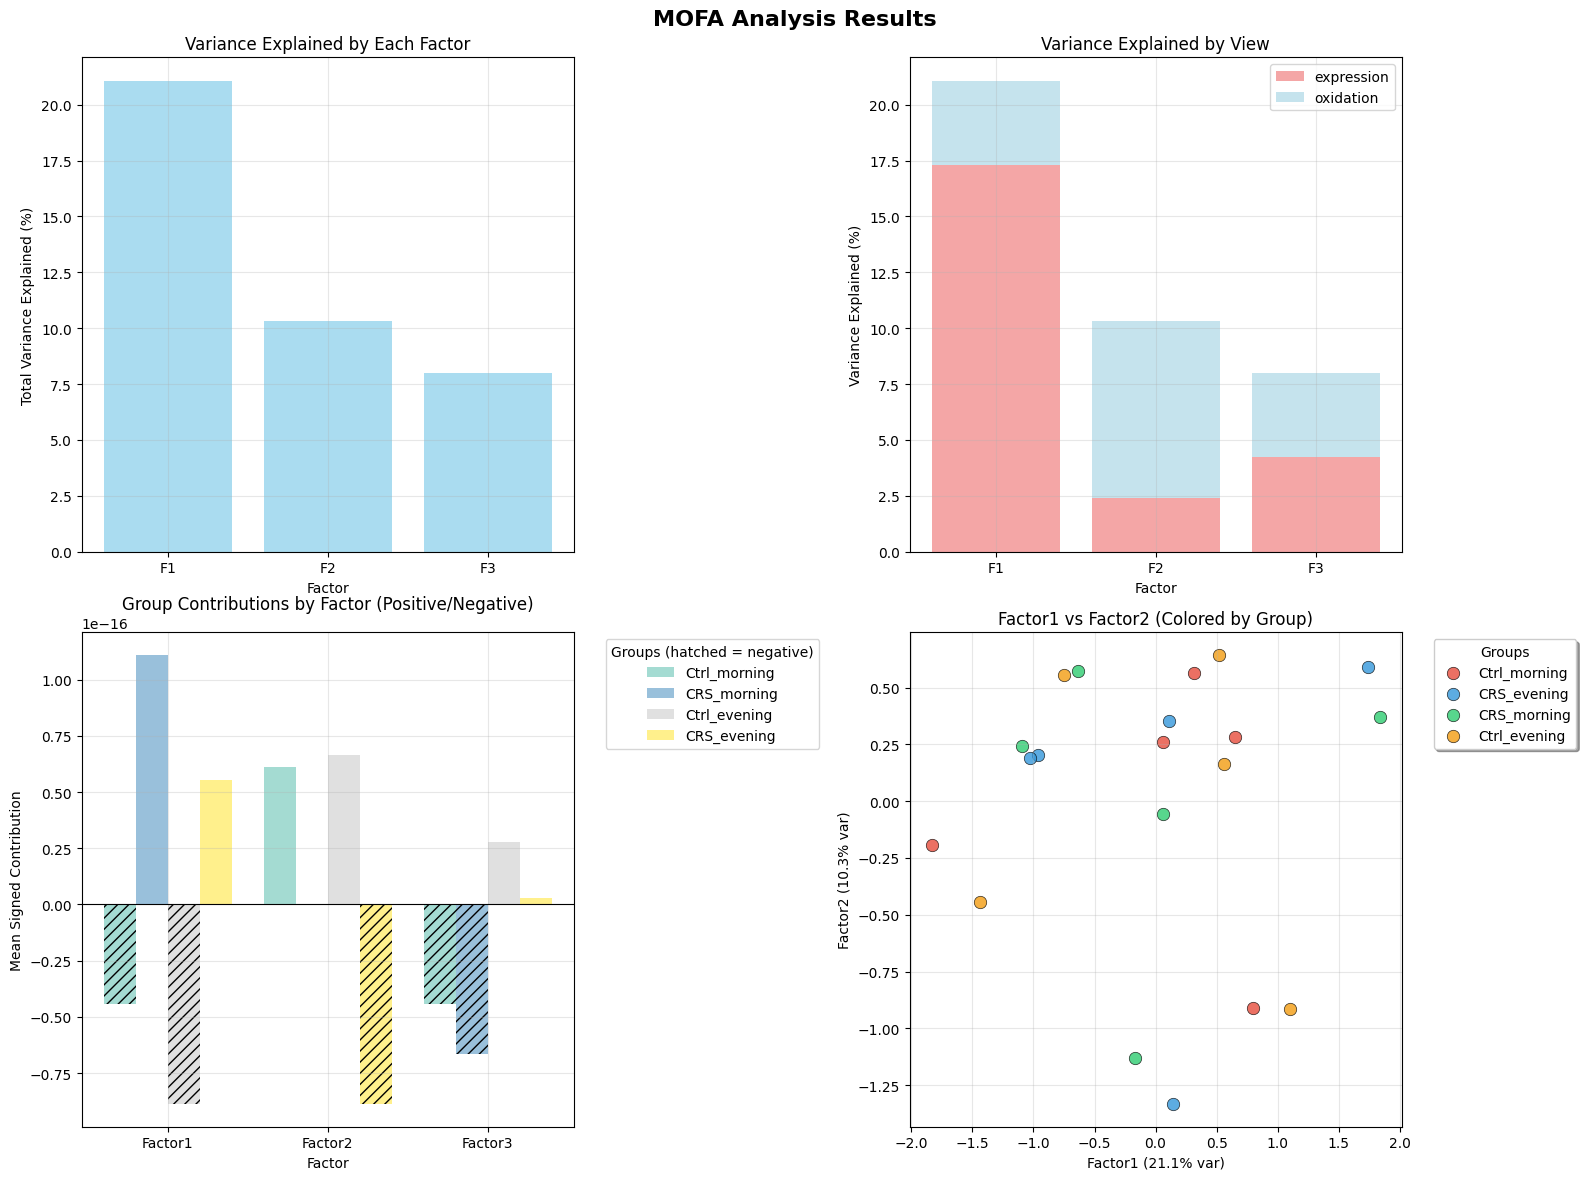


MOFA FACTOR INTERPRETATION

FACTOR1 (21.1% total variance):
--------------------------------------------------
Variance explained by view:
  expression: 17.3%
  oxidation: 3.8%

Top 10 features (by |weight|):
   1. ENSMUSG00000047921 (expression): +1.068
   2. ENSMUSG00000041135 (expression): +1.067
   3. ENSMUSG00000047773 (expression): -1.064
   4. ENSMUSG00000033068 (expression): +1.064
   5. ENSMUSG00000029661 (oxidation): -1.064
   6. ENSMUSG00000052406 (expression): +1.061
   7. ENSMUSG00000021557 (expression): +1.061
   8. ENSMUSG00000120507 (expression): +1.059
   9. ENSMUSG00000022892 (expression): +1.059
  10. ENSMUSG00000024816 (expression): +1.058

Cross-omics relevance: High
  Mean |expression weight|: 0.466
  Mean |oxidation weight|: 0.177

FACTOR2 (10.3% total variance):
--------------------------------------------------
Variance explained by view:
  expression: 2.4%
  oxidation: 7.9%

Top 10 features (by |weight|):
   1. ENSMUSG00000040770 (oxidation): -1.911
   2. ENS

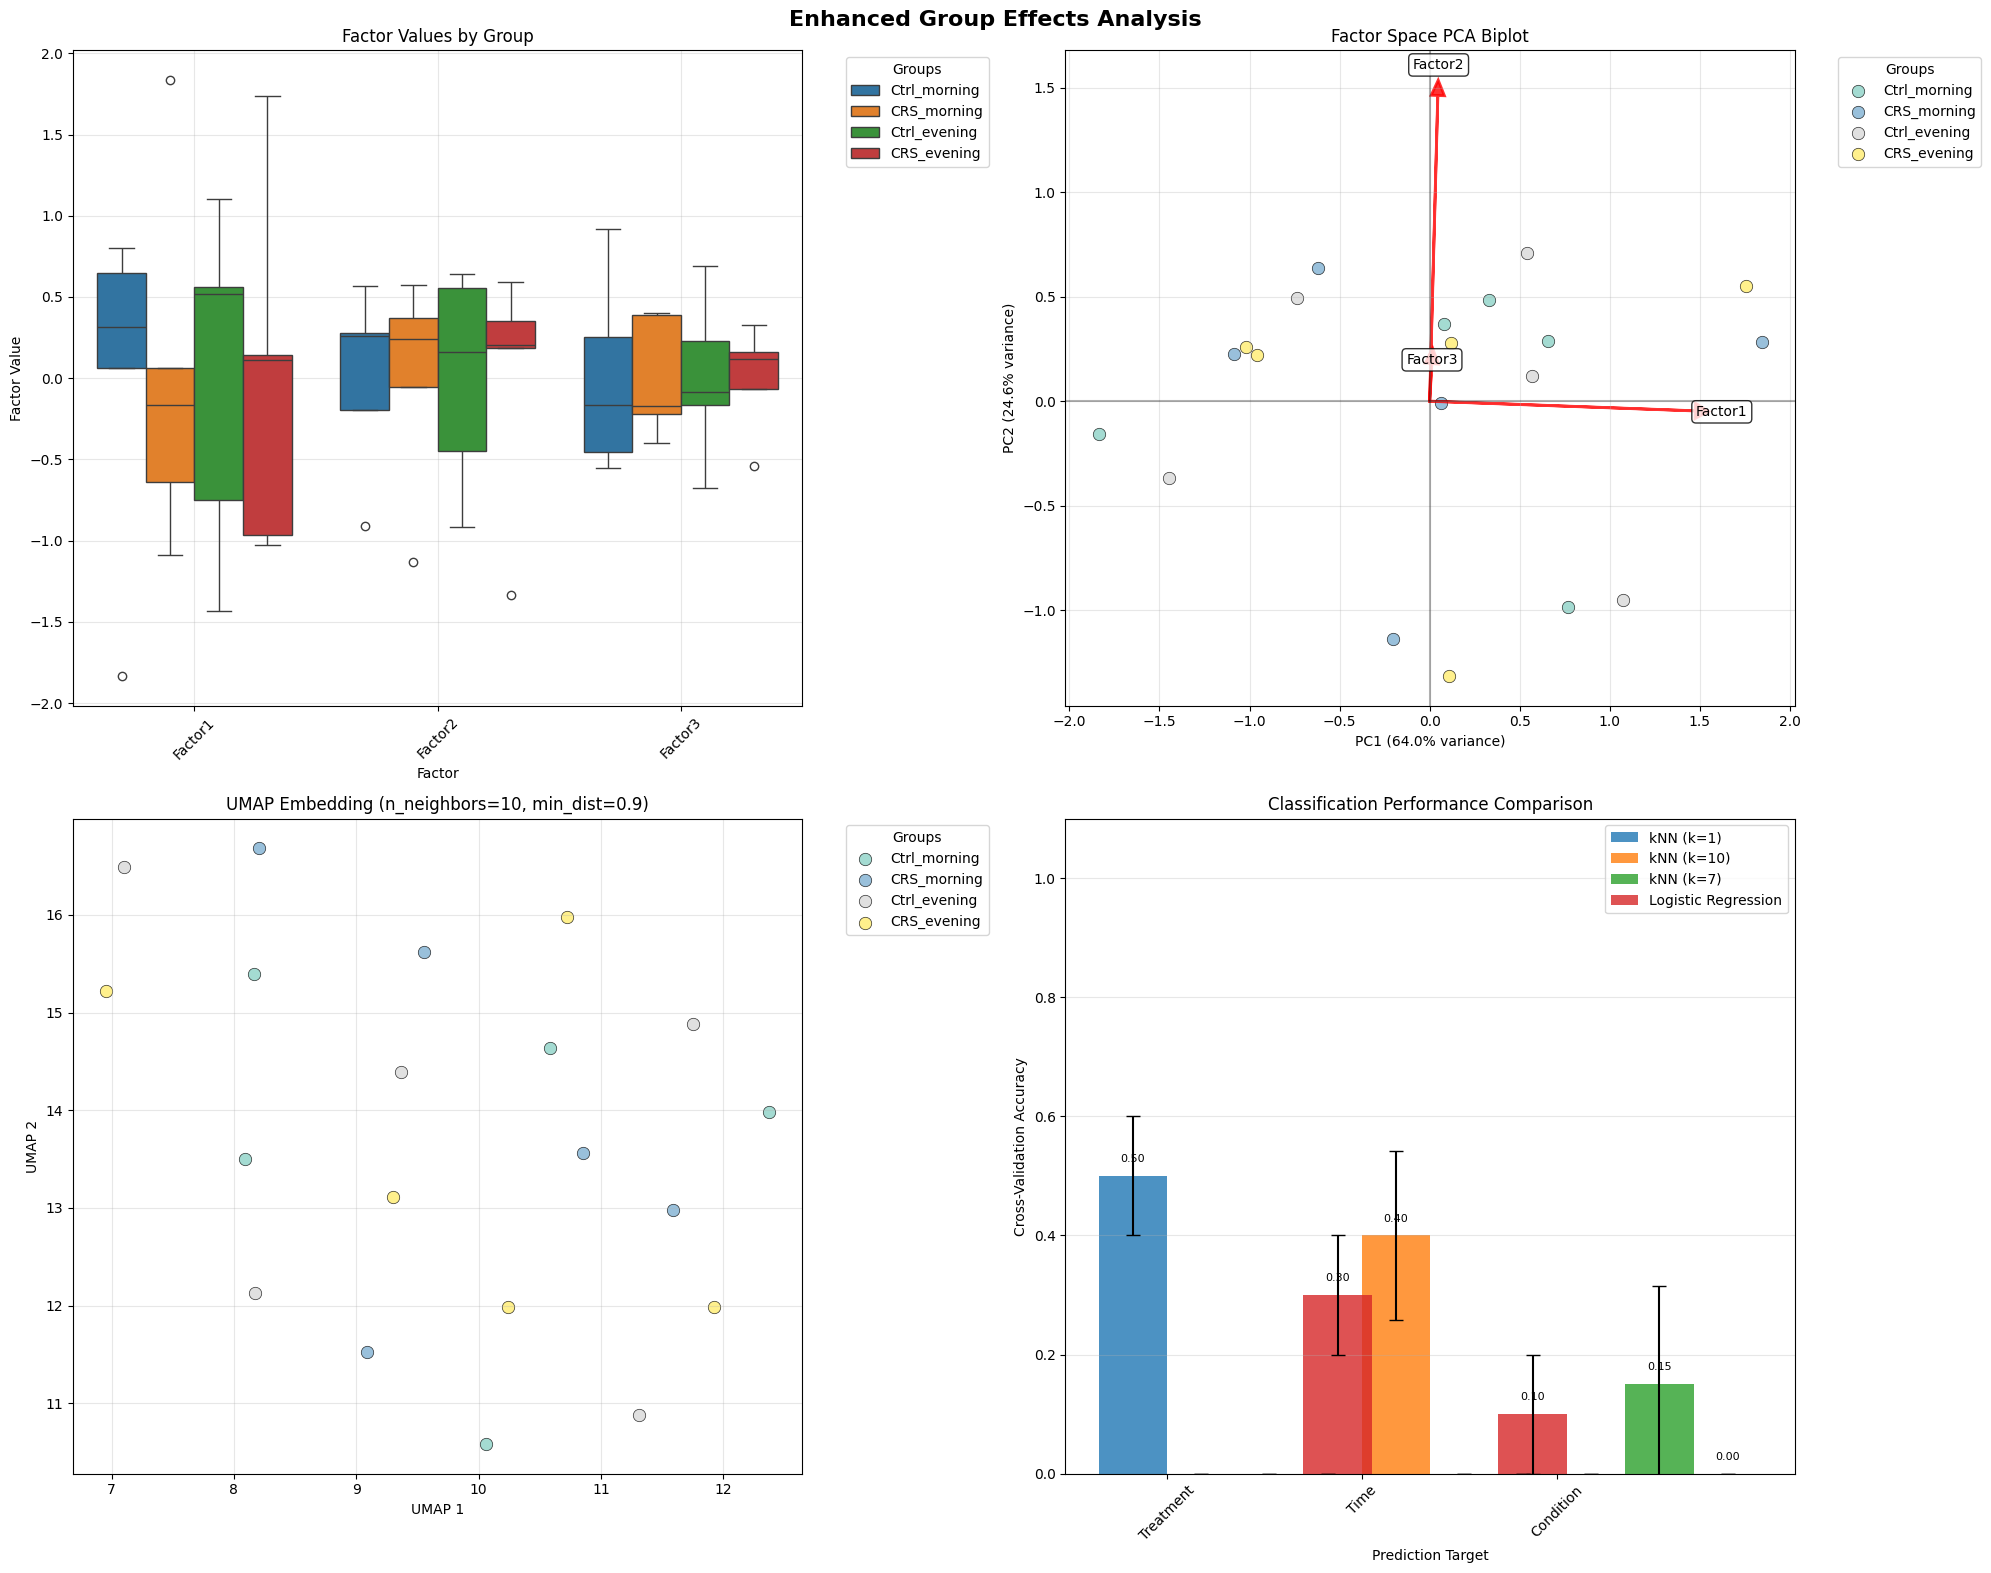


COMPREHENSIVE SUMMARY: ENHANCED GROUP EFFECTS ANALYSIS

1. TRADITIONAL ANOVA RESULTS:
   TREATMENT EFFECTS (Ctrl vs CRS):
     No significant treatment effects
   TIME EFFECTS (evening vs morning):
     No significant time effects
   TREATMENT × TIME INTERACTIONS:
     No significant interaction effects

2. MACHINE LEARNING CLASSIFICATION RESULTS:
   k-NEAREST NEIGHBORS:
     Treatment: 0.500 ± 0.100 (k=1)
     Time: 0.400 ± 0.141 (k=10)
     Condition: 0.150 ± 0.166 (k=7)
   LOGISTIC REGRESSION:
     Treatment: 0.300 ± 0.100
       Top predictive factors: Factor1, Factor2, Factor3
     Time: 0.100 ± 0.100
       Top predictive factors: Factor1, Factor2, Factor3
     Condition: 0.000 ± 0.000
       Top predictive factors: Factor2, Factor1, Factor3

3. UMAP DIMENSIONALITY REDUCTION:
   Best parameters: n_neighbors=10, min_dist=0.9
   kNN accuracy in UMAP space: 0.200
   UMAP preserved local structure while maintaining classification performance

4. OVERALL CONCLUSIONS:
   Best classifi

In [34]:
! source ~/mofa_clean_env/bin/activate

EXPR_PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/Mouse_brain_Sept2024/gene_annotation2/CRS_Morning_Evening_TPM_rearr.csv"
OXID_PATH = "../data_normalized/gene_bodies_Normalized.csv"

expr_df, oxid_df = load_data(EXPR_PATH, OXID_PATH)

expr_df_log = expr_df.copy()
expr_df_log['Expression_level'] = np.log1p(expr_df['Expression_level'])

oxid_df_log = oxid_df.copy()  
oxid_df_log['median_normalized_damage'] = np.log1p(oxid_df['median_normalized_damage'])

# For MOFA (requires mofapy2 installation):
mofa_results = run_complete_mofa_analysis(expr_df_log, oxid_df_log,  "../images/mofa_results/gene_bodies")

Loading expression data...
Loading oxidation data...
STARTING MOFA ANALYSIS PIPELINE

PREPARING DATA FOR MOFA ANALYSIS - OPTIMAL VERSION
Common groups: ['Ctrl_morning', 'CRS_morning', 'Ctrl_evening', 'CRS_evening']
Total genes: 52,649
Target genes per group: 15,000

STEP 1: Light zero-inflation filtering
  Using threshold 0.2 in ≥1 samples
  Genes remaining: 23,846 (was 52,649)
  Filtered out: 28,803 genes (54.7%)

Processing group: Ctrl_morning
  Common samples: 5
  Common genes after expression filtering: 23569
  Step 2: Moderate variance filtering (target: 15,000 genes)
    Expression variance - Min: 0.000000, Median: 0.014899, Max: 9.787654
    Oxidation variance - Min: 0.000332, Median: 0.052808, Max: 0.613864
    Target: 15,000 genes from 23,569 available
    Using 36.4% percentile cutoff
    Selected 20,404 genes
  Step 3: Standardization
    Final data shape: (20404, 5)
    Expression range: [-1.998, 2.000]
    Oxidation range: [-1.995, 2.000]

Processing group: CRS_morning
  C

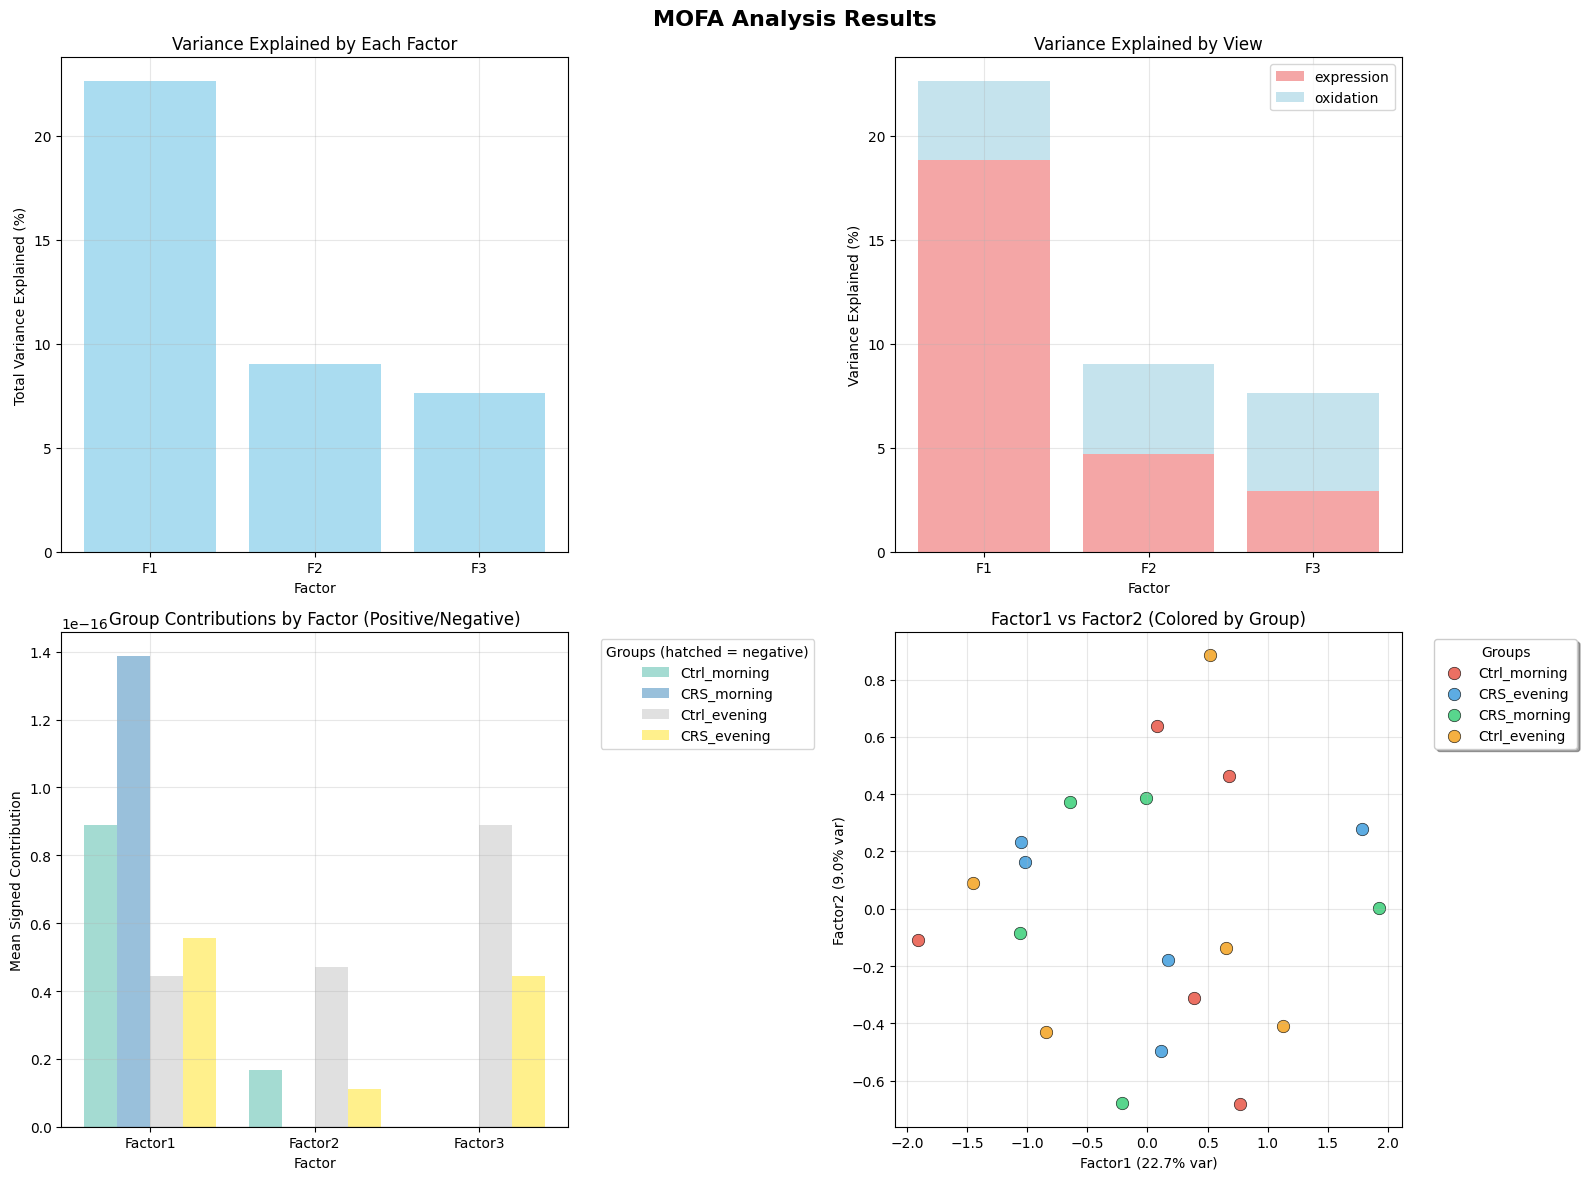


MOFA FACTOR INTERPRETATION

FACTOR1 (22.7% total variance):
--------------------------------------------------
Variance explained by view:
  expression: 18.8%
  oxidation: 3.8%

Top 10 features (by |weight|):
   1. ENSMUSG00000040824 (expression): +1.022
   2. ENSMUSG00000103741 (expression): -1.022
   3. ENSMUSG00000028563 (expression): +1.020
   4. ENSMUSG00000009418 (expression): +1.019
   5. ENSMUSG00000011752 (expression): +1.017
   6. ENSMUSG00000097998 (expression): +1.017
   7. ENSMUSG00000062995 (expression): +1.016
   8. ENSMUSG00000026112 (expression): +1.015
   9. ENSMUSG00000041570 (expression): +1.015
  10. ENSMUSG00000052299 (expression): +1.015

Cross-omics relevance: High
  Mean |expression weight|: 0.458
  Mean |oxidation weight|: 0.211

FACTOR2 (9.0% total variance):
--------------------------------------------------
Variance explained by view:
  expression: 4.7%
  oxidation: 4.3%

Top 10 features (by |weight|):
   1. ENSMUSG00000078938 (oxidation): -2.772
   2. ENS

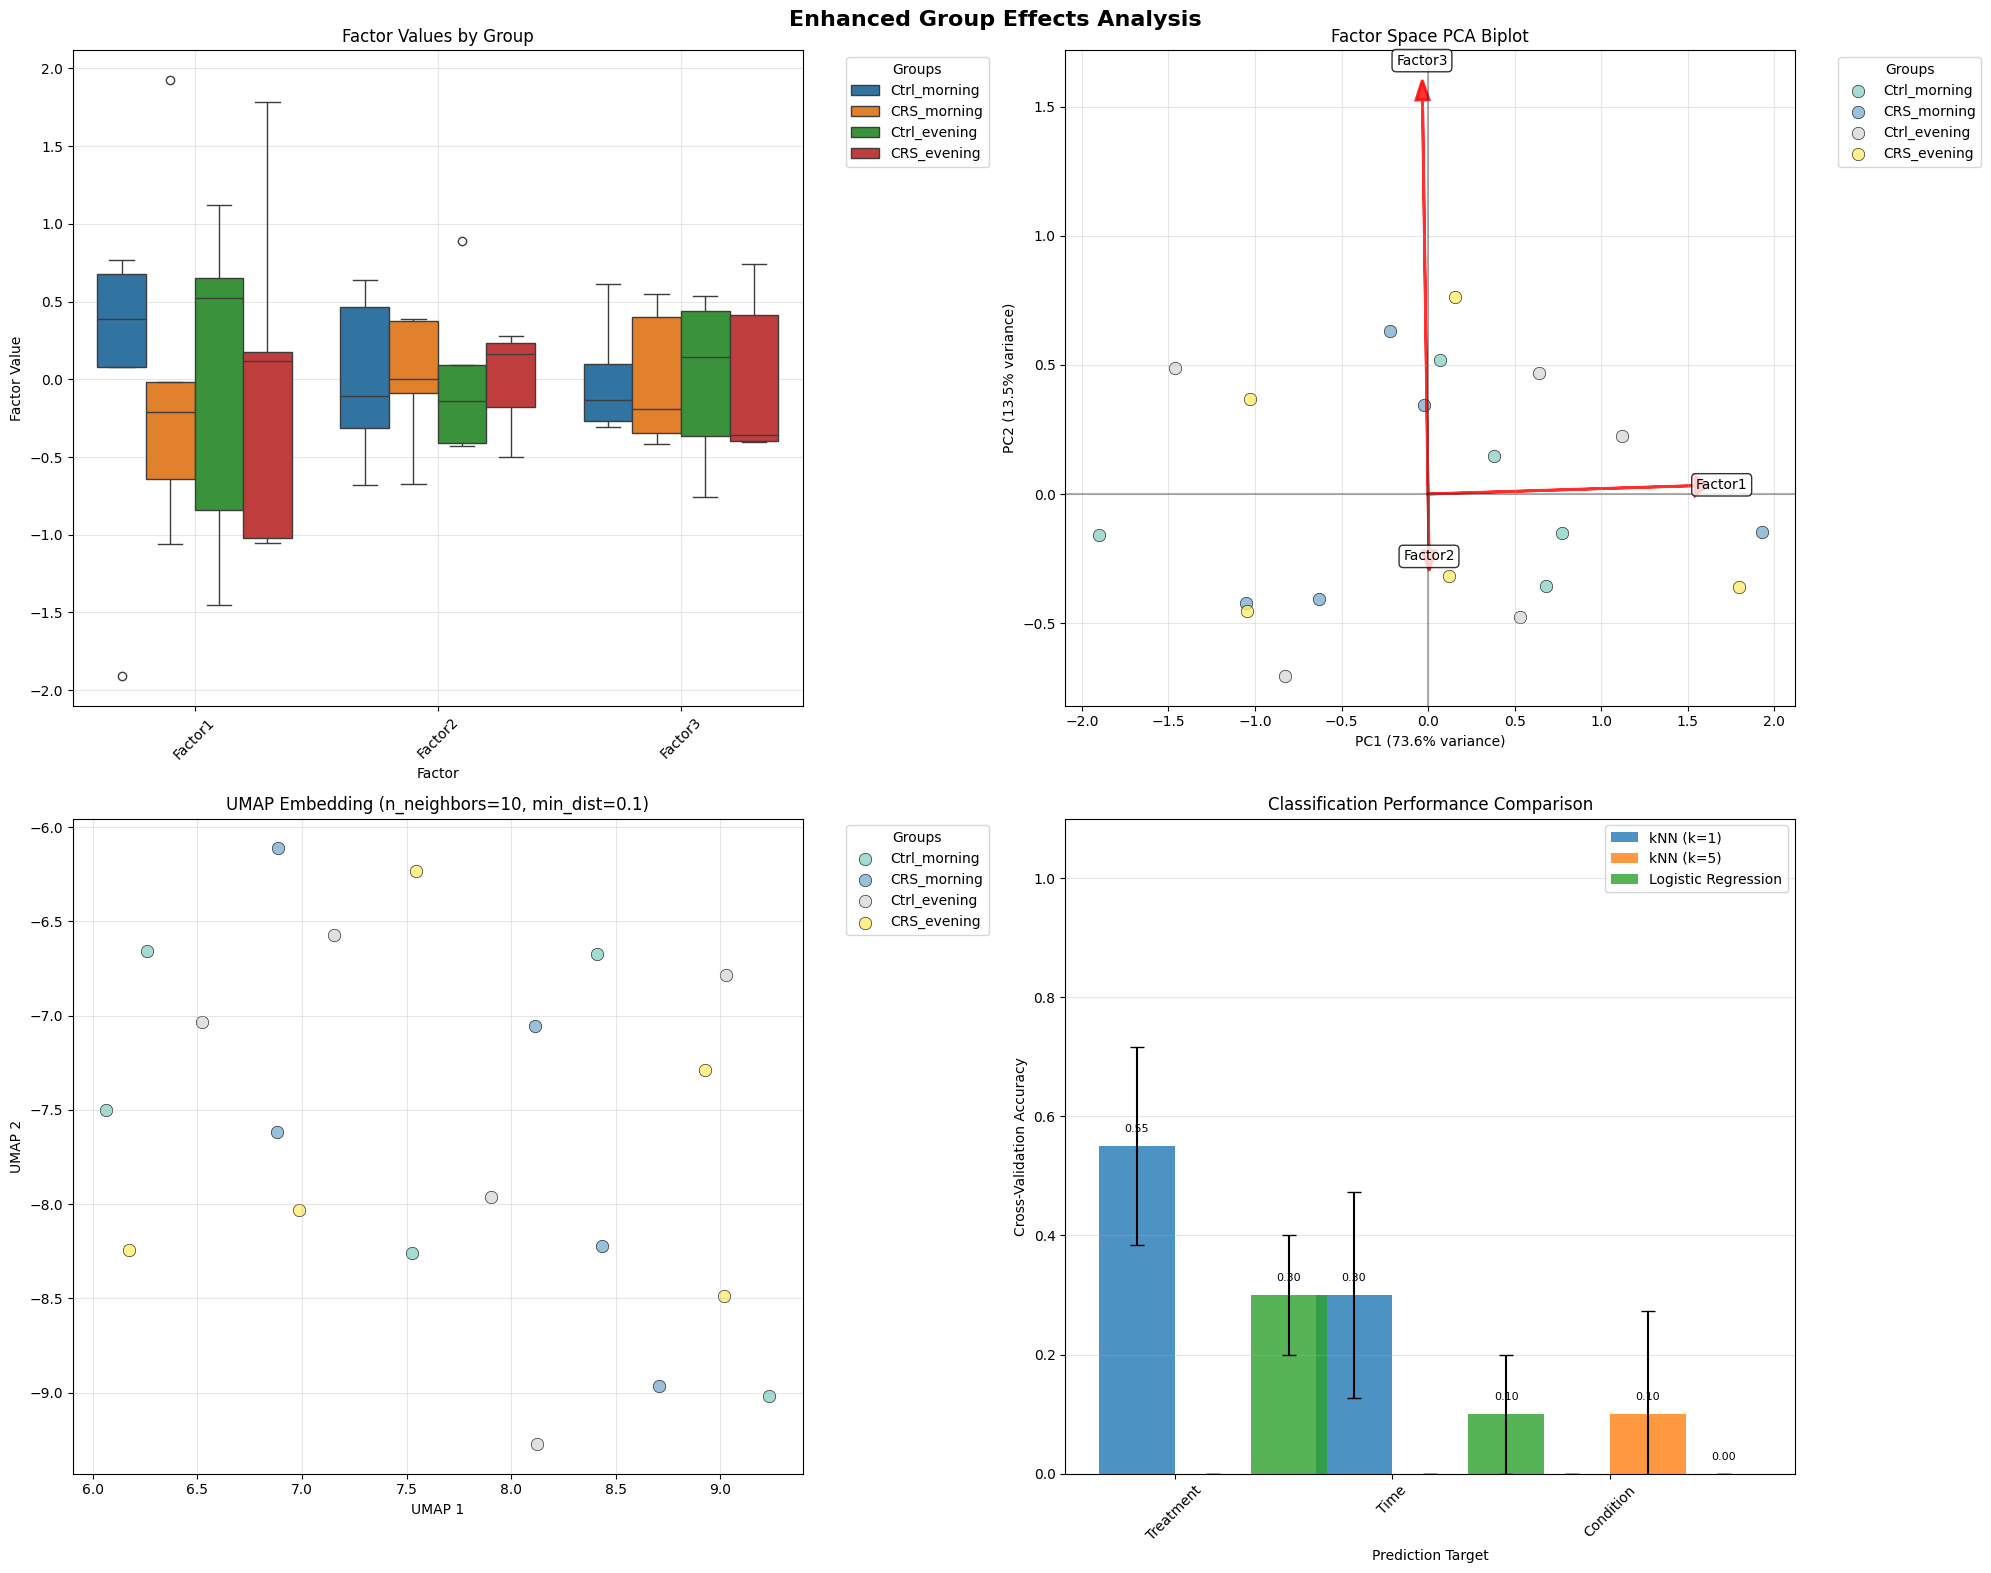


COMPREHENSIVE SUMMARY: ENHANCED GROUP EFFECTS ANALYSIS

1. TRADITIONAL ANOVA RESULTS:
   TREATMENT EFFECTS (Ctrl vs CRS):
     No significant treatment effects
   TIME EFFECTS (evening vs morning):
     No significant time effects
   TREATMENT × TIME INTERACTIONS:
     No significant interaction effects

2. MACHINE LEARNING CLASSIFICATION RESULTS:
   k-NEAREST NEIGHBORS:
     Treatment: 0.550 ± 0.166 (k=1)
     Time: 0.300 ± 0.173 (k=1)
     Condition: 0.100 ± 0.173 (k=5)
   LOGISTIC REGRESSION:
     Treatment: 0.300 ± 0.100
       Top predictive factors: Factor1, Factor2, Factor3
     Time: 0.100 ± 0.100
       Top predictive factors: Factor1, Factor2, Factor3
     Condition: 0.000 ± 0.000
       Top predictive factors: Factor2, Factor3, Factor1

3. UMAP DIMENSIONALITY REDUCTION:
   Best parameters: n_neighbors=10, min_dist=0.1
   kNN accuracy in UMAP space: 0.250
   UMAP preserved local structure while maintaining classification performance

4. OVERALL CONCLUSIONS:
   Best classific

In [35]:
! source ~/mofa_clean_env/bin/activate

EXPR_PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/Mouse_brain_Sept2024/gene_annotation2/CRS_Morning_Evening_TPM_rearr.csv"
OXID_PATH = "../data_normalized/promoters_Normalized.csv"

expr_df, oxid_df = load_data(EXPR_PATH, OXID_PATH)

expr_df_log = expr_df.copy()
expr_df_log['Expression_level'] = np.log1p(expr_df['Expression_level'])

oxid_df_log = oxid_df.copy()  
oxid_df_log['median_normalized_damage'] = np.log1p(oxid_df['median_normalized_damage'])

# For MOFA (requires mofapy2 installation):
mofa_results = run_complete_mofa_analysis(expr_df_log, oxid_df_log,  "../images/mofa_results/promoters")

Loading expression data...
Loading oxidation data...
STARTING MOFA ANALYSIS PIPELINE

PREPARING DATA FOR MOFA ANALYSIS - OPTIMAL VERSION
Common groups: ['Ctrl_morning', 'CRS_morning', 'Ctrl_evening', 'CRS_evening']
Total genes: 52,649
Target genes per group: 15,000

STEP 1: Light zero-inflation filtering
  Using threshold 0.2 in ≥1 samples
  Genes remaining: 23,846 (was 52,649)
  Filtered out: 28,803 genes (54.7%)

Processing group: Ctrl_morning
  Common samples: 5
  Common genes after expression filtering: 11603
  Step 2: Moderate variance filtering (target: 15,000 genes)
    Expression variance - Min: 0.000000, Median: 0.014223, Max: 3.279475
    Oxidation variance - Min: 0.000000, Median: 0.052553, Max: 1.207688
    Target: 15,000 genes from 11,603 available
    Using 0.0% percentile cutoff
    Selected 11,595 genes
  Step 3: Standardization
    Final data shape: (11595, 5)
    Expression range: [-1.998, 2.000]
    Oxidation range: [-1.988, 2.000]

Processing group: CRS_morning
  Co

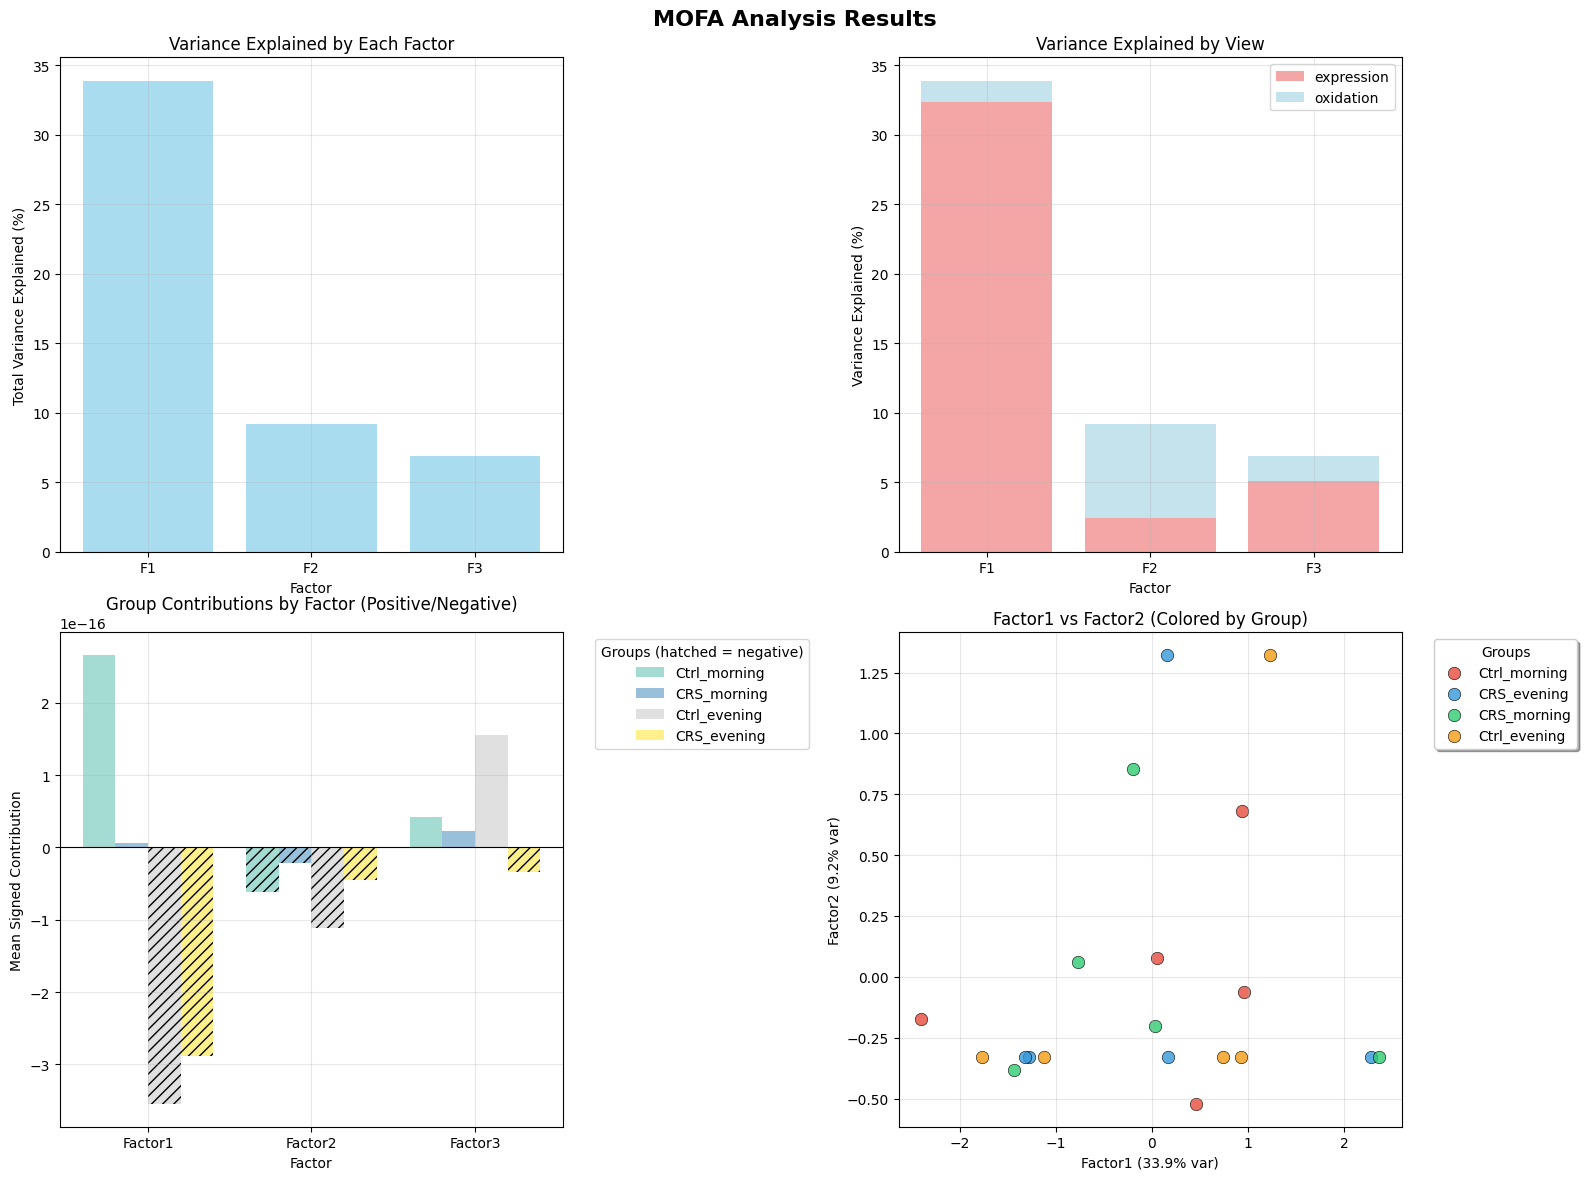


MOFA FACTOR INTERPRETATION

FACTOR1 (33.9% total variance):
--------------------------------------------------
Variance explained by view:
  expression: 32.3%
  oxidation: 1.5%

Top 10 features (by |weight|):
   1. ENSMUSG00000060427 (expression): +0.906
   2. ENSMUSG00000025047 (expression): +0.881
   3. ENSMUSG00000050192 (expression): +0.879
   4. ENSMUSG00000026620 (expression): +0.875
   5. ENSMUSG00000026000 (expression): +0.869
   6. ENSMUSG00000002718 (expression): +0.847
   7. ENSMUSG00000062380 (expression): +0.838
   8. ENSMUSG00000120906 (expression): +0.836
   9. ENSMUSG00000020230 (expression): +0.836
  10. ENSMUSG00000034109 (expression): +0.836

Cross-omics relevance: Low
  Mean |expression weight|: 0.482
  Mean |oxidation weight|: 0.038

FACTOR2 (9.2% total variance):
--------------------------------------------------
Variance explained by view:
  expression: 2.4%
  oxidation: 6.8%

Top 10 features (by |weight|):
   1. ENSMUSG00000035953 (oxidation): +2.154
   2. ENSM

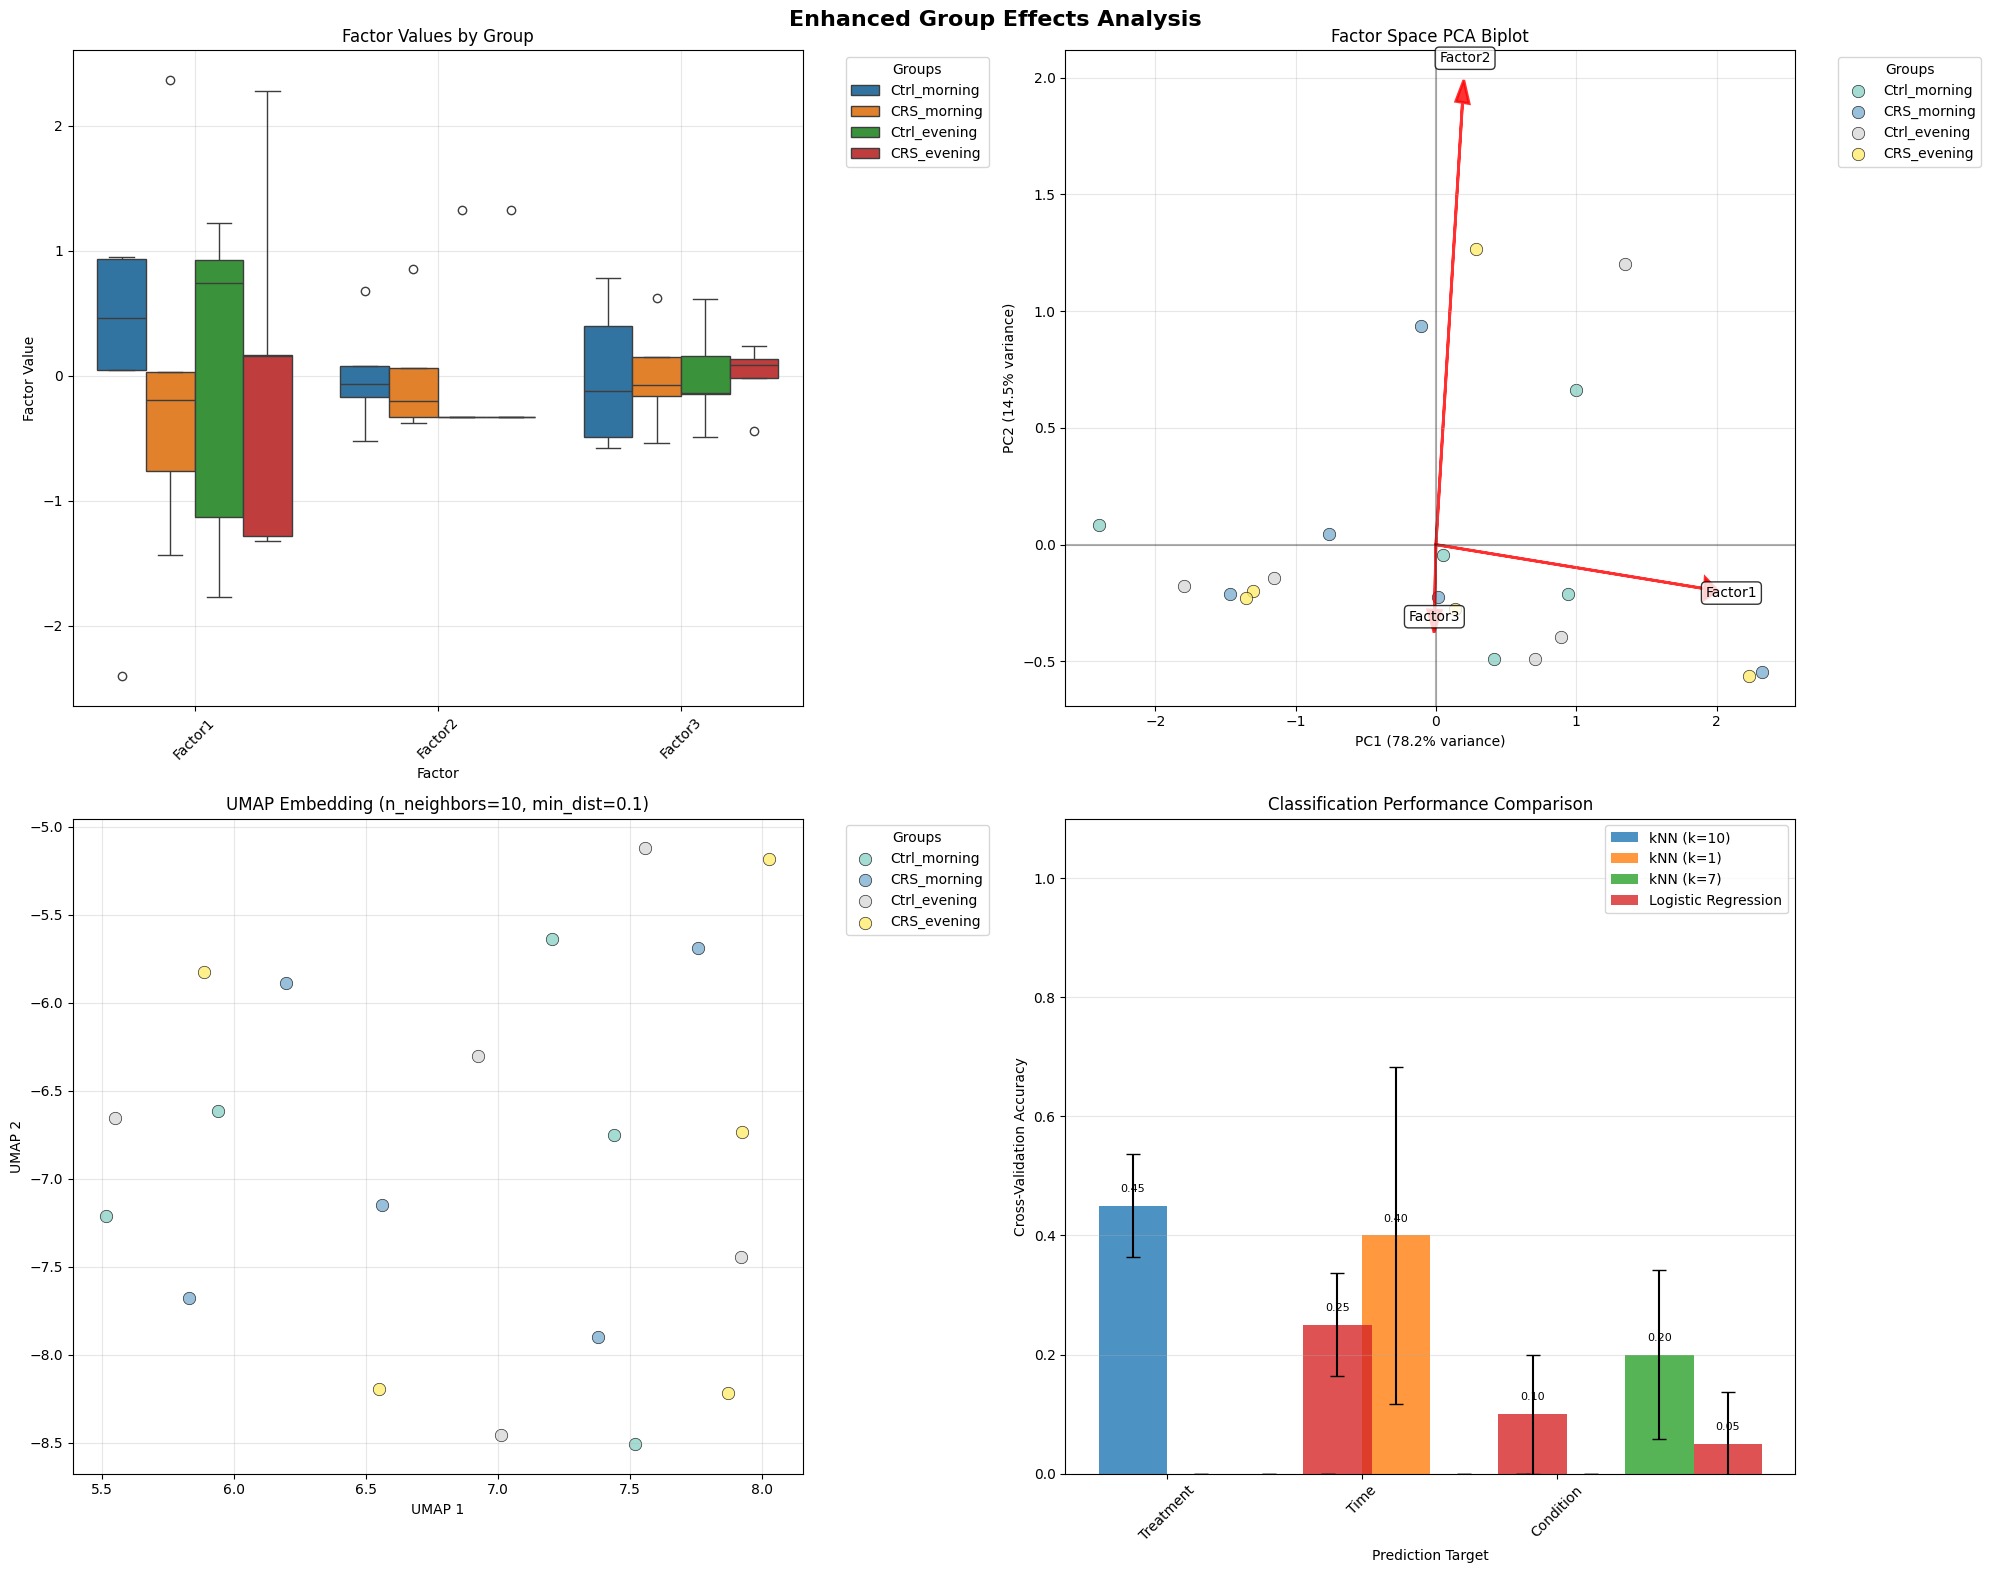


COMPREHENSIVE SUMMARY: ENHANCED GROUP EFFECTS ANALYSIS

1. TRADITIONAL ANOVA RESULTS:
   TREATMENT EFFECTS (Ctrl vs CRS):
     No significant treatment effects
   TIME EFFECTS (evening vs morning):
     No significant time effects
   TREATMENT × TIME INTERACTIONS:
     No significant interaction effects

2. MACHINE LEARNING CLASSIFICATION RESULTS:
   k-NEAREST NEIGHBORS:
     Treatment: 0.450 ± 0.087 (k=10)
     Time: 0.400 ± 0.283 (k=1)
     Condition: 0.200 ± 0.141 (k=7)
   LOGISTIC REGRESSION:
     Treatment: 0.250 ± 0.087
       Top predictive factors: Factor1, Factor2, Factor3
     Time: 0.100 ± 0.100
       Top predictive factors: Factor1, Factor2, Factor3
     Condition: 0.050 ± 0.087
       Top predictive factors: Factor1, Factor3, Factor2

3. UMAP DIMENSIONALITY REDUCTION:
   Best parameters: n_neighbors=10, min_dist=0.1
   kNN accuracy in UMAP space: 0.150
   UMAP preserved local structure while maintaining classification performance

4. OVERALL CONCLUSIONS:
   Best classifi

In [36]:
! source ~/mofa_clean_env/bin/activate

EXPR_PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/Mouse_brain_Sept2024/gene_annotation2/CRS_Morning_Evening_TPM_rearr.csv"
OXID_PATH = "../data_normalized/cpg_Normalized_with_genes.csv"

expr_df, oxid_df = load_data(EXPR_PATH, OXID_PATH)

expr_df_log = expr_df.copy()
expr_df_log['Expression_level'] = np.log1p(expr_df['Expression_level'])

oxid_df_log = oxid_df.copy()  
oxid_df_log['median_normalized_damage'] = np.log1p(oxid_df['median_normalized_damage'])

# For MOFA (requires mofapy2 installation):
mofa_results = run_complete_mofa_analysis(expr_df_log, oxid_df_log,  "../images/mofa_results/cpg")